### Loading the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the dataset containing information of CHENNAI cars

In [2]:
df=pd.read_csv('cleaned_chennai_cars.csv')
df.head()

,Unnamed: 0,id,car_from,it,ft,bt,km,transmission,ownerNo,owner,...,Turbo Charger,Turning Radius,Tyre Type,Value Configuration,Values per Cylinder,Wheel Base,Wheel Size,Width,d,id.3
0,0,0,chennai,0,Petrol,SUV,"20,000",Automatic,1,1st Owner,...,Yes,NaN,"Tubeless, Radial",NaN,4.0,2500,16,1790,NaN,0
1,1,1,chennai,0,Petrol,Minivans,"20,687",Manual,1,1st Owner,...,No,4.5 metres,Tubeless Tyres,DOHC,4.0,2350mm,NaN,1475mm,NaN,1
2,2,2,chennai,0,Petrol,SUV,"30,000",Manual,1,1st Owner,...,Yes,5.0,"Tubeless,Radial",SOHC,4.0,2500,16,1758,NaN,2
3,3,3,chennai,0,Petrol,Hatchback,"59,247",Manual,1,1st Owner,...,No,4.7 metres,Tubeless,SOHC,3.0,2380mm,NaN,1595mm,NaN,3
4,4,4,chennai,0,Petrol,Hatchback,"50,000",Manual,1,1st Owner,...,No,5.1 meters,"Tubeless,Radial",SOHC,4.0,2530mm,15,1694mm,NaN,4


In [3]:
df.shape

(1419, 248)

In [4]:
len(df.columns)

248

### Segragating categorical and numerical columns

In [5]:
#categorical columns list
all_cc=[]
#numerical columns list
all_nc=[]
for i in df.columns:
    if df[i].dtype=='O':
        all_cc.append(i)
    else:
        all_nc.append(i)
print('categorical_columns:',all_cc)
print()
print('numerical_columns:',all_nc)

categorical_columns: ['car_from', 'ft', 'bt', 'km', 'transmission', 'owner', 'oem', 'model', 'variantName', 'price', 'priceActual', 'trendingText_heading', 'trendingText_desc', 'Registration Year', 'Insurance Validity', 'Fuel Type', 'Seats', 'Kms Driven', 'RTO', 'Ownership', 'Engine Displacement', 'Transmission', 'Acceleration', 'Alloy Wheel Size', 'BoreX Stroke', 'Cargo Volumn', 'Color', 'Compression Ratio', 'Drive Type', 'Engine', 'Engine Type', 'Front Brake Type', 'Front Tread', 'Fuel Suppy System', 'Gear Box', 'Gross Weight', 'Ground Clearance Unladen', 'Height', 'Kerb Weight', 'Length', 'Max Power', 'Max Torque', 'Mileage', 'Rear Brake Type', 'Rear Tread', 'Steering Type', 'Super Charger', 'Top Speed', 'Torque', 'Turbo Charger', 'Turning Radius', 'Tyre Type', 'Value Configuration', 'Wheel Base', 'Wheel Size', 'Width']

numerical_columns: ['Unnamed: 0', 'id', 'it', 'ownerNo', 'modelYear', 'centralVariantId', 'priceSaving', 'priceFixedText', 'id.1', 'Year of Manufacture', 'Accessory

In [6]:
# I will use the features in the car_features list along with the features selected using SHAP analysis
car_features=['No Door Numbers', 'No of Cylinder','Values per Cylinder']

### Engineering the 'price' column

In [7]:
x=list(df['price'].apply(lambda x :x.lower()))
am=[]
cu=[]
for i in x:
    try:
        if (i.endswith('e')):
            r=list(i)
            r1=r.index('c')
            am.append(round(float(i[2:r1-1])*10000000,0))
            cu.append(i[r1:])
        elif (i.endswith('h')):
            r=list(i)
            r1=r.index('l')
            am.append(round(float(i[2:r1-1])*100000,0))
            cu.append(i[r1:])
        else:
            d=list(i)
            e=[]
            for j in d:
                if j.isnumeric()==True:
                    e.append(j)
            am.append(float(''.join(e)))
            cu.append('thousand')
    except ValueError:
            am.append(np.nan)
            cu.append(np.nan)

In [8]:
#New price column - this will be the 'target' variable
df['price_new']=am

In [9]:
#Lets take a look at the original and preprocessed price columns
df[['price','price_new']].head()

,price,price_new
0,₹ 11.50 Lakh,1150000.0
1,₹ 4.15 Lakh,415000.0
2,₹ 7.50 Lakh,750000.0
3,₹ 3.98 Lakh,398000.0
4,₹ 5.50 Lakh,550000.0


### Engineering the 'km' column

In [10]:
kms=[]
for i in list(df['km']):
    d=list(i)
    e=[]
    for j in d:
        if j.isnumeric()==True:
            e.append(j)
    kms.append(float(''.join(e)))
    

In [11]:
#new km column
df['kms']=kms

In [12]:
df[['kms','km','Kms Driven']]

,kms,km,Kms Driven
0,20000.0,"20,000","20,000 Kms"
1,20687.0,"20,687","20,687 Kms"
2,30000.0,"30,000","30,000 Kms"
3,59247.0,"59,247","59,247 Kms"
4,50000.0,"50,000","50,000 Kms"
...,...,...,...
1414,42891.0,"42,891","42,891 Kms"
1415,59100.0,"59,100","59,100 Kms"
1416,55913.0,"55,913","55,913 Kms"
1417,65000.0,"65,000","65,000 Kms"


### Combining the selected features in the list 'all_selected_features'

In [13]:
all_selected_features=['bt','owner', 'oem','Registration Year','Engine Displacement',
      'Seating Capacity','Alloy Wheel Size','Turbo Charger', 'Engine',  'Front Brake Type',
 'Gear Box', 'Height', 'Kerb Weight', 'Length', 'Max Power', 
'Max Torque', 'Mileage', 'Rear Brake Type', 'Wheel Base','Width','kms','price_new']
for i in car_features:
    all_selected_features.append(i)

In [14]:
df=df[all_selected_features]
df.head()

,bt,owner,oem,Registration Year,Engine Displacement,Seating Capacity,Alloy Wheel Size,Turbo Charger,Engine,Front Brake Type,...,Max Torque,Mileage,Rear Brake Type,Wheel Base,Width,kms,price_new,No Door Numbers,No of Cylinder,Values per Cylinder
0,SUV,1st Owner,Kia,2022,998 cc,5,16,Yes,998 CC,Disc,...,172nm@1500-4000rpm,NaN,Drum,2500,1790,20000.0,1150000.0,5,3.0,4.0
1,Minivans,1st Owner,Maruti,Feb 2015,1196 cc,7,NaN,No,1196 CC,Ventilated Disc,...,101Nm@3000rpm,15.37 kmpl,Drum,2350mm,1475mm,20687.0,415000.0,5,4.0,4.0
2,SUV,1st Owner,Nissan,2021,999 cc,5,16,Yes,999 CC,Disc,...,160Nm@2800-3600rpm,20 kmpl,Drum,2500,1758,30000.0,750000.0,5,3.0,4.0
3,Hatchback,1st Owner,Hyundai,May 2015,1086 cc,5,NaN,No,1086 CC,Ventilated Disc,...,99.04Nm@4500rpm,19.81 kmpl,Drum,2380mm,1595mm,59247.0,398000.0,5,4.0,3.0
4,Hatchback,1st Owner,Honda,2015,1199 cc,5,15,No,1199 CC,Disc,...,110Nm@4800rpm,18.7 kmpl,Drum,2530mm,1694mm,50000.0,550000.0,5,4.0,4.0


In [15]:
df_nv=pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})
df_nv

,dtypes,null_count,unique_values,percent_of_null_values
bt,object,0,7,0.000000
owner,object,0,6,0.000000
oem,object,0,30,0.000000
Registration Year,object,0,195,0.000000
Engine Displacement,object,20,91,0.014094
Seating Capacity,int64,0,7,0.000000
Alloy Wheel Size,object,468,16,0.329810
Turbo Charger,object,144,5,0.101480
Engine,object,0,92,0.000000
Front Brake Type,object,19,20,0.013390


**I will impute the columns having more than 30% missing values and drop null rows having less 3% missing values**

### Engineering the 'bt' column and renaming the new column as 'body_type'

In [16]:
df['body_type']=df['bt'].apply(lambda x:str(x).lower())
df['body_type'].value_counts()

body_type
hatchback    593
sedan        406
suv          352
muv           63
minivans       3
hybrids        1
coupe          1
Name: count, dtype: int64

In [17]:
df['body_type']=['other' if i=='muv' or i=='minivans' or i=='hybrids' or i=='coupe'  else i for i in list(df['body_type'])]
df['body_type'].value_counts()

body_type
hatchback    593
sedan        406
suv          352
other         68
Name: count, dtype: int64

### Engineering the 'owner' column 

In [18]:
df['owner']=df['owner'].apply(lambda x:x.lower())
df['owner'].value_counts()

owner
1st owner    1004
2nd owner     321
3rd owner      64
0th owner      22
4th owner       7
5th owner       1
Name: count, dtype: int64

In [19]:
df['owner']=df['owner'].map({'0th owner':'no_owner','1st owner':'1_owner','2nd owner':'2_owners','3rd owner':'>2_owners','4th owner':'>2_owners','5th owner':'>2_owners'})
df['owner'].value_counts()

owner
1_owner      1004
2_owners      321
>2_owners      72
no_owner       22
Name: count, dtype: int64

### Engineering the 'oem' column 

In [20]:
df['oem']=df['oem'].apply(lambda x:x.lower())
df['oem'].value_counts()

oem
maruti                319
hyundai               266
honda                 184
tata                   82
volkswagen             76
ford                   63
renault                53
toyota                 50
bmw                    42
mercedes-benz          41
mahindra               41
audi                   37
skoda                  31
kia                    27
datsun                 23
mg                     14
nissan                 13
jeep                   12
chevrolet              10
volvo                   7
fiat                    6
land rover              6
mitsubishi              4
mini                    3
jaguar                  3
isuzu                   2
citroen                 1
mahindra renault        1
mahindra ssangyong      1
lexus                   1
Name: count, dtype: int64

In [21]:
car_make=['mg','nissan','jeep','chevrolet','volvo','fiat','land rover','mitsubishi','mini','jaguar','isuzu','citroen',
          'mahindra renault','mahindra ssangyong','lexus']
df['oem']=['other' if i in car_make  else i for i in list(df['oem'])]
df['oem'].value_counts()

oem
maruti           319
hyundai          266
honda            184
other             84
tata              82
volkswagen        76
ford              63
renault           53
toyota            50
bmw               42
mercedes-benz     41
mahindra          41
audi              37
skoda             31
kia               27
datsun            23
Name: count, dtype: int64

### Engineering the 'Registration Year' column 

In [22]:
df['registration_year']=df['Registration Year'].apply(lambda x:str(x).lower())
df['registration_year'].value_counts()[:10]

registration_year
2017                     37
aug 2017                 24
2019                     23
2022                     23
aug 2018                 22
third party insurance    22
2021                     21
jul 2018                 20
jun 2022                 20
jun 2018                 20
Name: count, dtype: int64

In [23]:
df['registration_year']=df['Registration Year'].apply(lambda x:x[-4:])
df['registration_year'].value_counts()

registration_year
2017    192
2016    173
2018    170
2019    140
2021    117
2022    100
2020     96
2015     92
2014     83
2013     57
2012     48
2010     36
2011     32
ance     22
2009     19
2023     11
2008     11
2007      6
2002      4
2005      4
2004      2
2006      2
2003      2
Name: count, dtype: int64

In [24]:
ry=['2007','2006','2005','2004','2003','2002',]
df['registration_year']=['before_2008' if i in ry  else i for i in list(df['registration_year'])]
df['registration_year']=['not_specified' if i=='ance' else i for i in list(df['registration_year'])]
df['registration_year'].value_counts()

registration_year
2017             192
2016             173
2018             170
2019             140
2021             117
2022             100
2020              96
2015              92
2014              83
2013              57
2012              48
2010              36
2011              32
not_specified     22
before_2008       20
2009              19
2008              11
2023              11
Name: count, dtype: int64

### Engineering the 'Seating Capacity' column 

In [25]:
df['seating_capacity']=df['Seating Capacity'].apply(lambda x:str(x))
df['seating_capacity'].value_counts()

seating_capacity
5     1267
7      114
6       19
4        9
8        8
10       1
9        1
Name: count, dtype: int64

In [26]:
df['seating_capacity']=df['seating_capacity'].map({'4':'4','5':'5','6':'6',
                                                      '7':'7',
                                                      '8':'>=8','9':'>=8','10':'>=8'})
df['seating_capacity'].value_counts()

seating_capacity
5      1267
7       114
6        19
>=8      10
4         9
Name: count, dtype: int64

In [27]:
df.fillna({'seating_capacity':'5'},inplace=True)

### Engineering the 'Engine Displacement' column 

In [28]:
df['engine_displacement']=df['Engine Displacement'].apply(lambda x:str(x).lower())
df['engine_displacement'].value_counts()[:50]

engine_displacement
1197 cc      248
1199 cc      114
998 cc       107
1498 cc       82
1497 cc       73
manual        67
999 cc        56
1198 cc       54
1248 cc       49
1591 cc       29
799 cc        25
1995 cc       24
1968 cc       24
1956 cc       23
automatic     23
1396 cc       22
1086 cc       21
1493 cc       21
nan           20
2143 cc       20
1598 cc       18
1462 cc       18
796 cc        17
1373 cc       12
2393 cc       12
1582 cc       11
1999 cc       11
1461 cc       10
1399 cc        9
2179 cc        9
2993 cc        9
1451 cc        9
1950 cc        9
1496 cc        8
1998 cc        7
814 cc         7
1353 cc        7
2494 cc        6
1984 cc        6
2198 cc        6
1798 cc        5
2755 cc        5
1499 cc        5
1368 cc        5
1196 cc        5
2967 cc        5
1298 cc        4
1997 cc        4
1969 cc        4
1186 cc        4
Name: count, dtype: int64

In [29]:
df['engine_displacement']=df['Engine Displacement'].apply(lambda x:str(x).lower())
ed=[]
for i in list(df['engine_displacement']):
    d=list(i)
    e=[]
    if i=='nan':
        ed.append(np.nan)
    elif i=='automatic':
        ed.append(9)
    elif i=='manual':
        ed.append(6)
    else:
        for j in d:
            if j.isnumeric()==True:
                e.append(j)

        
        ed.append(float(''.join(e)))
        
print(len(ed))    
df['engine_displacement']=ed
print(df['engine_displacement'].value_counts().sort_values())
print(set(ed))

1419
engine_displacement
1172.0      1
793.0       1
1599.0      1
1799.0      1
2995.0      1
         ... 
1497.0     73
1498.0     82
998.0     107
1199.0    114
1197.0    248
Name: count, Length: 91, dtype: int64
{0.0, nan, 6, 9, 1047.0, 4134.0, 1582.0, 1586.0, 1591.0, 4663.0, 1086.0, 1598.0, 1599.0, 2143.0, 1120.0, 2179.0, 2694.0, 2184.0, 2696.0, 1172.0, 2198.0, 2199.0, 1186.0, 1193.0, 1194.0, 1196.0, 1197.0, 1198.0, 1199.0, 2755.0, 1248.0, 1796.0, 1798.0, 1799.0, 1298.0, 793.0, 796.0, 799.0, 814.0, 2354.0, 1330.0, 1353.0, 1364.0, 1368.0, 2393.0, 1373.0, 2400.0, 1896.0, 2925.0, 1390.0, 1395.0, 1396.0, 1399.0, 1405.0, 1422.0, 2967.0, 1950.0, 1956.0, 2982.0, 936.0, 1451.0, 2987.0, 2477.0, 1968.0, 2993.0, 1969.0, 2995.0, 1461.0, 1462.0, 2999.0, 2998.0, 2997.0, 2487.0, 1468.0, 2494.0, 1984.0, 2499.0, 1991.0, 1482.0, 1995.0, 1997.0, 1998.0, 1999.0, 1493.0, 1496.0, 1497.0, 1498.0, 1499.0, 2015.0, 2021.0, 998.0, 999.0}


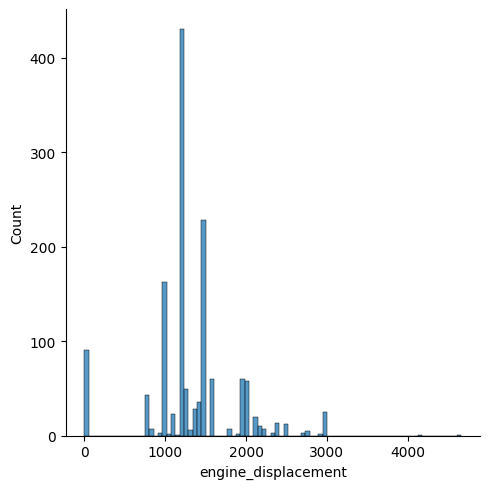

mean: 1323.360972122945 median: 1199.0


In [30]:
sns.displot(df['engine_displacement'])
plt.show()
print('mean:',df['engine_displacement'].mean(),'median:',df['engine_displacement'].median())

In [31]:
df.fillna({'engine_displacement':df['engine_displacement'].median()},inplace=True)

### Engineering the 'Alloy Wheel Size' column 

In [32]:
df['alloy_wheel_size']=df['Alloy Wheel Size'].apply(lambda x:str(x).lower())
df['alloy_wheel_size'].value_counts()

alloy_wheel_size
nan    468
16     282
15     206
17     131
14     124
18      72
13      41
r16     21
r15     19
19      19
12       9
r17      8
20       5
r19      4
r14      4
r18      4
21       2
Name: count, dtype: int64

In [33]:
al=[]
for i in list(df['alloy_wheel_size']):
    if i=='nan':
        al.append(np.nan)
    elif i[0]!='r':
        al.append(f'r{i}')
    else:
        al.append(i)
df['alloy_wheel_size']=al
df['alloy_wheel_size'].value_counts()

alloy_wheel_size
r16    303
r15    225
r17    139
r14    128
r18     76
r13     41
r19     23
r12      9
r20      5
r21      2
Name: count, dtype: int64

In [34]:
df.fillna({'alloy_wheel_size':'r16'},inplace=True)

In [35]:
df['alloy_wheel_size'].isnull().sum()

0

### Engineering the 'Turbo Charger' column

In [36]:
df['turbo_charger']=df['Turbo Charger'].apply(lambda x:str(x).lower())
print(df['turbo_charger'].value_counts())

turbo_charger
no      758
yes     507
nan     144
twin     10
Name: count, dtype: int64


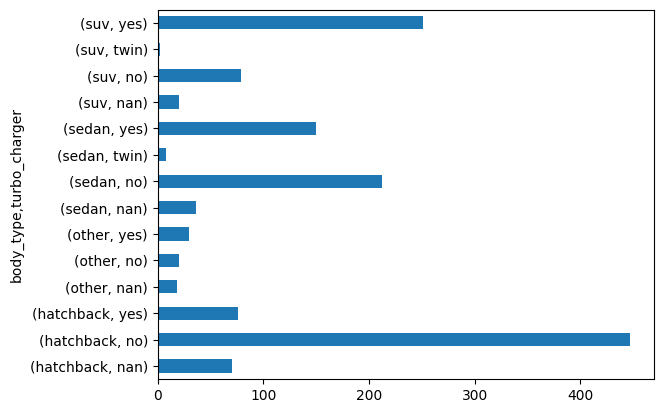

In [37]:
df.groupby(['body_type','turbo_charger'])['turbo_charger'].count().plot(kind='barh')
plt.show()

In [38]:
z=list(df[df['turbo_charger']=='nan']['body_type'])
z

['suv',
 'other',
 'hatchback',
 'suv',
 'other',
 'sedan',
 'sedan',
 'hatchback',
 'hatchback',
 'sedan',
 'other',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'hatchback',
 'other',
 'hatchback',
 'hatchback',
 'hatchback',
 'suv',
 'hatchback',
 'hatchback',
 'hatchback',
 'other',
 'suv',
 'hatchback',
 'sedan',
 'sedan',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'suv',
 'hatchback',
 'sedan',
 'hatchback',
 'sedan',
 'other',
 'other',
 'sedan',
 'hatchback',
 'hatchback',
 'sedan',
 'sedan',
 'sedan',
 'sedan',
 'sedan',
 'sedan',
 'suv',
 'other',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'suv',
 'sedan',
 'sedan',
 'sedan',
 'suv',
 'suv',
 'sedan',
 'hatchback',
 'suv',
 'hatchback',
 'sedan',
 'other',
 'hatchback',
 'other',
 'hatchback',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'hatchback',
 'sedan',
 'hatchback',
 'sedan',
 'hatchback',
 'sedan',
 'sedan',
 'other',
 'suv',
 'sedan',
 'ot

In [39]:
for h in range(len(z)):
    if z[h]=='suv' or z[h]=='other':
        df.loc[(df['body_type']==z[h]) & (df['turbo_charger'].isnull()),['turbo_charger']]='yes'
    elif z[h]=='hatchback' or z[h]=='sedan':
        df.loc[(df['body_type']==z[h]) & (df['turbo_charger'].isnull()),['turbo_charger']]='no'

In [40]:
df['turbo_charger'].isnull().sum()

0

### Engineering the 'Front Brake Type' column

In [41]:
df.columns

Index(['bt', 'owner', 'oem', 'Registration Year', 'Engine Displacement',
       'Seating Capacity', 'Alloy Wheel Size', 'Turbo Charger', 'Engine',
       'Front Brake Type', 'Gear Box', 'Height', 'Kerb Weight', 'Length',
       'Max Power', 'Max Torque', 'Mileage', 'Rear Brake Type', 'Wheel Base',
       'Width', 'kms', 'price_new', 'No Door Numbers', 'No of Cylinder',
       'Values per Cylinder', 'body_type', 'registration_year',
       'seating_capacity', 'engine_displacement', 'alloy_wheel_size',
       'turbo_charger'],
      dtype='object')

In [42]:
df['front_brake_type']=df['Front Brake Type'].apply(lambda x:str(x).lower())
print(df['front_brake_type'].value_counts())

front_brake_type
disc                                912
ventilated disc                     429
nan                                  19
ventilated discs                     16
disc                                 12
solid disc                            6
disk                                  6
ventilated disk                       4
drum                                  3
multilateral disc                     2
ventilated disc                       2
disc & caliper type                   2
vantilated disc                       1
booster assisted ventilated disc      1
ventlated disc                        1
disc, 236 mm                          1
caliper ventilated disc               1
abs                                   1
Name: count, dtype: int64


In [43]:
df['front_brake_type'].unique()

array(['disc', 'ventilated disc', 'booster assisted ventilated disc',
       'disc ', 'disc & caliper type', 'nan', 'ventilated discs',
       'ventilated disk', 'vantilated disc', 'abs', 'solid disc',
       'multilateral disc', 'drum', 'disk', 'ventlated disc',
       'disc, 236 mm', 'caliper ventilated disc', 'ventilated disc '],
      dtype=object)

In [44]:
df['front_brake_type']=df['front_brake_type'].map({'disc':'solid disc','ventilated disc':'ventilated discs',
                                                   'ventilated discs':'ventilated discs','disc ':'solid disc',
                                                   'solid disc':'solid disc','disk':'solid disc','ventilated disk':'ventilated discs',
                                                   'ventilated disc ':'ventilated discs','vantilated disc':'ventilated discs',
                                                   'ventlated disc':'ventilated discs','disc, 236 mm':'solid disc','nan':'solid disc',
                                                   'drum':'other','multilateral disc':'other','disc & caliper type':'other',
                                                   'booster assisted ventilated disc':'other','caliper ventilated disc':'other',
                                                   'abs':'other'})
print(df['front_brake_type'].value_counts())

front_brake_type
solid disc          956
ventilated discs    453
other                10
Name: count, dtype: int64


### Engineering the 'Gear Box' column

In [45]:
df['gear_box']=df['Gear Box'].apply(lambda x:str(x).lower())
print(df['gear_box'].value_counts())

gear_box
5 speed                                            769
6 speed                                            165
5-speed                                             84
6-speed                                             57
8 speed                                             45
7 speed                                             43
5 speed                                             35
cvt                                                 29
4 speed                                             22
nan                                                 19
9 speed                                             18
6 speed                                             13
5                                                   12
8-speed steptronic                                   9
6-speed imt                                          8
7-speed dct                                          8
7-speed s-tronic                                     6
8-speed                                              5
5

In [46]:
df['gear_box'].unique()

array(['7-speed dct', '5 speed', '7 speed', '5 speed ', '8 speed',
       '6 speed', '5', '6 speed imt', 'nan', '7-speed', 'cvt',
       '7g dct 7-speed dual clutch transmission ', '5-speed',
       '5 speed cvt', '6 speed ', '7 speed ', '9 speed', '6-speed',
       '6-speed imt', 'five speed', '4 speed',
       '5 speed at+ paddle shifters', '4-speed', '7 speed dsg',
       '4 speed ', '8 speed cvt', '6-speed at', '8-speed',
       '7-speed s-tronic ', '8-speed steptronic', '6-speed autoshift',
       '6', '9g-tronic', 'ivt', '9 speed tronic', '9g-tronic automatic',
       'ags', '6-speed dct', '6 speed at', '9-speed', '8 speed tiptronic',
       '7-speed dsg', 'six speed manual', 'imt', '8 speed sport',
       '6 speed with sequential shift', '6-speed ivt',
       '7-speed steptronic', '8', '8-speed ',
       'five speed manual transmission', '7 speed dct',
       'five speed manual transmission gearbox', 'amg speedshift dct 8g',
       'amg 7-speed dct', 'e-cvt', '8 speed ', '7-spee

In [47]:
gb=[]
for i in list(df['gear_box']):
    if i=='5 speed' or i=='5-speed' or i=='5 speed ' or i=='5' or i=='five speed' :
        gb.append('5 speed')
    elif i=='five speed manual transmission gearbox' :
        gb.append('5 speed manual transmission')
    elif i=='five speed manual transmission':
        gb.append('5 speed manual transmission')
    elif i in ['7 speed ','7-speed']:
        gb.append('7 speed')
    elif i in ['7-speed stronic','7-speed s-tronic','7-speed s-tronic ']:
        gb.append('7-speed s-tronic')
    elif i in [ '7 speed dct','7-speed dct']:
        gb.append( '7 speed dct')
    elif i in ['8-speed','8', '8-speed ','8 speed ']:
        gb.append('8 speed')
    elif i in ['6 speed ','6-speed','6']:
        gb.append('6 speed')
    elif i in ['6-speed at','6-speed at' ,'6 speed at',]:
        gb.append('6-speed at')
    elif i in ['six speed manual',]:
        gb.append('6-speed manual') 
    else:
        gb.append(i)
        

In [48]:
df['gear_box']=gb
print(df['gear_box'].value_counts())

gear_box
5 speed                                            901
6 speed                                            237
8 speed                                             53
7 speed                                             48
cvt                                                 29
4 speed                                             22
nan                                                 19
9 speed                                             18
7 speed dct                                         10
8-speed steptronic                                   9
7-speed s-tronic                                     9
6-speed imt                                          8
7-speed dsg                                          4
5 speed cvt                                          4
4 speed                                              3
6-speed dct                                          3
ags                                                  3
6 speed imt                                          3
9

In [49]:
x=list(df['gear_box'])
gb1=['other' if x.count(i)<10 else i for i in x ]

In [50]:
df['gear_box']=gb1
print(df['gear_box'].value_counts())

gear_box
5 speed        901
6 speed        237
other           82
8 speed         53
7 speed         48
cvt             29
4 speed         22
nan             19
9 speed         18
7 speed dct     10
Name: count, dtype: int64


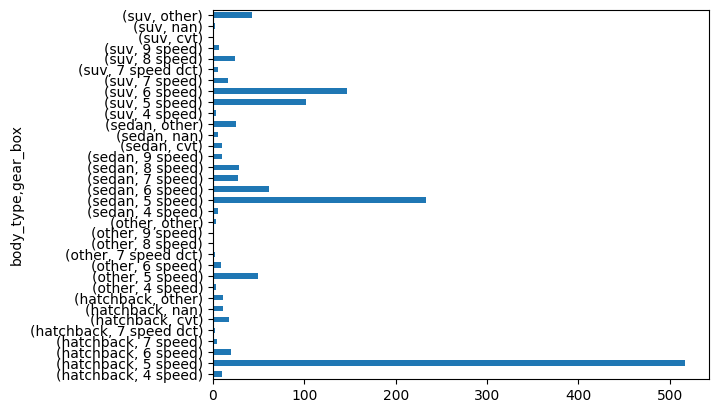

In [51]:
df.groupby(['body_type','gear_box'])['gear_box'].count().plot(kind='barh')
plt.show()

In [52]:
df.fillna({'gear_box':'5 speed'},inplace=True)

In [53]:
df['gear_box'].isnull().sum()

0

### Engineering the 'Mileage' column

In [54]:
df['mileage']=df['Mileage'].apply(lambda x:str(x).lower())
print(df['mileage'].value_counts())

mileage
18.6 kmpl     60
17 kmpl       48
nan           44
18.9 kmpl     43
21.4 kmpl     30
              ..
21.72 kmpl     1
13.53 kmpl     1
13.38 kmpl     1
27.62 kmpl     1
14.28 kmpl     1
Name: count, Length: 312, dtype: int64


In [55]:
avs=[]
for i in list(df['mileage']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b))))
df['mileage']=avs
df['mileage'].value_counts()

mileage
19.0    214
18.0    147
17.0    143
21.0    143
20.0    138
16.0    101
22.0     96
23.0     70
15.0     58
25.0     57
24.0     56
14.0     41
13.0     36
26.0     28
12.0     14
27.0     10
28.0     10
11.0      5
8.0       4
9.0       3
10.0      1
Name: count, dtype: int64

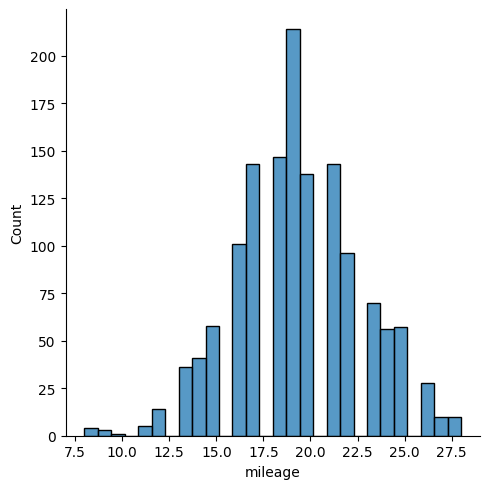

mean: 19.26909090909091 median: 19.0


In [56]:
sns.displot(df['mileage'])
plt.show()
print('mean:',df['mileage'].mean(),'median:',df['mileage'].median())

In [57]:
df.fillna({'mileage':df['mileage'].median()},inplace=True)

In [58]:
df['mileage'].isnull().sum()

0

### Engineering the 'Wheel Base' column

In [59]:
df['wheel_base' ]=df['Wheel Base' ].apply(lambda x:str(x).lower())
print(df['wheel_base' ].value_counts())

wheel_base
2425mm     77
2600mm     71
2570mm     64
2520mm     61
2450mm     58
           ..
2776mm      1
2807mm      1
2480mm      1
2490 mm     1
2677mm      1
Name: count, Length: 178, dtype: int64


In [60]:
avs=[]
for i in list(df['wheel_base']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b))))
df['wheel_base']=avs
df['wheel_base'].value_counts()

wheel_base
2450.0    96
2600.0    82
2425.0    77
2570.0    64
2520.0    62
          ..
2335.0     1
2440.0     1
2480.0     1
2462.0     1
2677.0     1
Name: count, Length: 127, dtype: int64

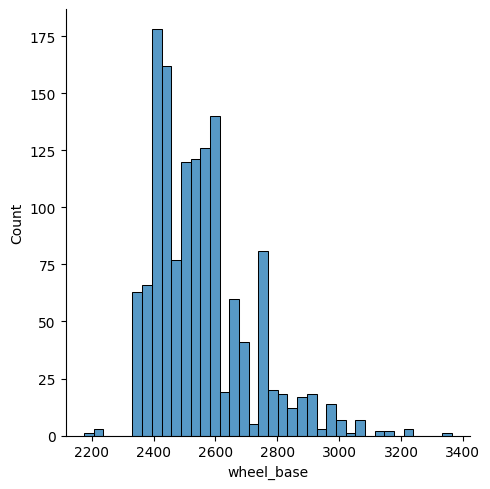

mean: 2552.358069164265 median: 2520.0


In [61]:
sns.displot(df['wheel_base'])
plt.show()
print('mean:',df['wheel_base'].mean(),'median:',df['wheel_base'].median())

In [62]:
df.fillna({'wheel_base':df['wheel_base'].median()},inplace=True)

In [63]:
df['wheel_base'].isnull().sum()

0

### Engineering the 'Height' column

In [64]:
df['height' ]=df['Height'].apply(lambda x:str(x).lower())
print(df['height'].value_counts())

height
1505mm       81
1520mm       56
1510mm       52
1475mm       51
1495mm       42
             ..
1530 mm       1
1710mm        1
1498-1501     1
1488mm        1
1672mm        1
Name: count, Length: 214, dtype: int64


In [65]:
avs=[]
for i in list(df['height']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['height']=avs
df['height'].value_counts()

height
1505.0    89
1520.0    72
1475.0    55
1530.0    53
1510.0    52
          ..
1666.0     1
1857.0     1
1651.0     1
1639.0     1
1672.0     1
Name: count, Length: 161, dtype: int64

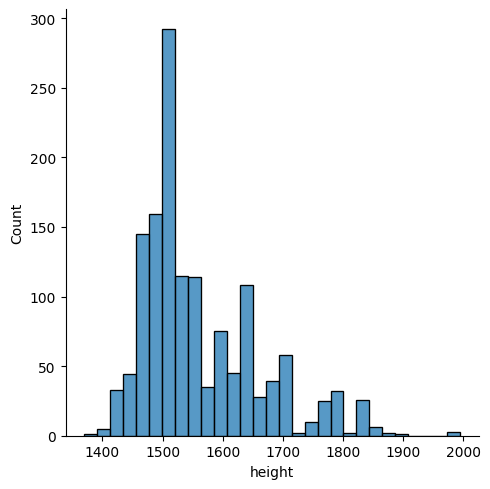

mean: 1562.0569395017794 median: 1530.0


In [66]:
sns.displot(df['height'])
plt.show()
print('mean:',df['height'].mean(),'median:',df['height'].median())

In [67]:
df.fillna({'height':df['height'].median()},inplace=True)

### Engineering the 'Kerb Weight' column

In [68]:
df['kerb_weight' ]=df['Kerb Weight'].apply(lambda x:str(x).lower())
print(df['kerb_weight'].value_counts())
df['kerb_weight'].unique()

kerb_weight
1066kg    40
935kg     29
1100kg    16
1100      15
1120      15
          ..
1615kg     1
2350       1
2345kg     1
1645       1
1720kg     1
Name: count, Length: 465, dtype: int64


array(['1465', '943kg', '1014', '860kg', '1042kg', '1800kg', '845kg',
       '860-895kg', '1690', '1320kg', '1170', '1066 kg', '1560', '1100',
       '1305kg', '1565', '1065kg', '2220', '940kg', '880', '950kg',
       '960kg', '1049kg', '1400kg', '1320', '1440', '1640kg', '1107kg',
       '920kg', '935kg', '810kg', '1790kg', '1103kg', '1146kg', '1565kg',
       '875kg', '1155', '1245', '1180', '1085kg', '1340', '1430',
       '1270kg', '955-990kg', '1228', '1735kg', '1955kg', '1198kg',
       '1135kg', '2330 kg', '1825kg', '1655kg', '2240', '1252kg',
       '1030kg', '1780', '1010', '1285', '1039kg', '1485', '1115kg',
       '1080', '1855', '890kg', '930', '905kg', '1,240kg', '1066',
       '990kg', '1044kg', '1300kg', '1010kg', '1405', '1120', '880kg',
       '1140', '1066kg', '1260kg', '1660', '870kg', '1145kg', '1069kg',
       '1084kg', '2152', '1190kg', '970', '915kg', '1545', '1879kg',
       '1160', '1761', '1755', '855-885', '2160kg', '1340kg', '1163kg',
       '1233kg', '880-9

In [69]:
avs=[]
for i in list(df['kerb_weight']):
    if i=='nan' or i=='kerb weight':
        avs.append(np.nan)
    
    elif i[0].isnumeric()==True:
        
        b=[]
        if '-' in list(i):
            r=i.index('-')
            for k in range(r):
                if i[k].isnumeric()==True or i[k]=='.':
                    b.append(i[k])
        else:   
            for j in i:
                    if j.isnumeric()==True or j=='.':
                        b.append(j)
        
        avs.append(round(float(''.join(b))))
df['kerb_weight']=avs
df['kerb_weight'].value_counts()

kerb_weight
1066.0    45
1100.0    31
935.0     30
880.0     20
860.0     18
          ..
980.0      1
1770.0     1
1350.0     1
1062.0     1
1685.0     1
Name: count, Length: 341, dtype: int64

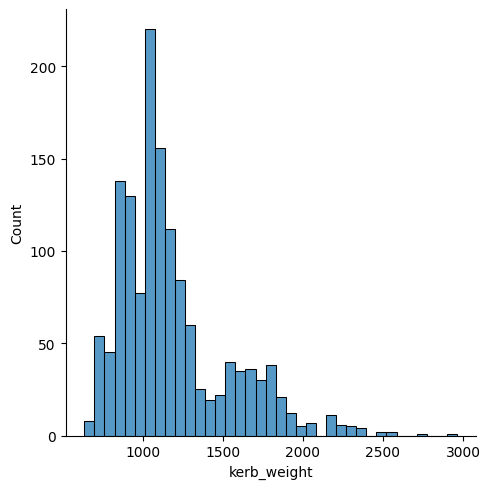

mean: 1183.2702702702702 median: 1100.0


In [70]:
sns.displot(df['kerb_weight'])
plt.show()
print('mean:',df['kerb_weight'].mean(),'median:',df['kerb_weight'].median())

In [71]:
df.fillna({'kerb_weight':df['kerb_weight'].median()},inplace=True)

### Engineering the 'Length' column

In [72]:
df['length' ]=df['Length'].apply(lambda x:str(x).lower())
print(df['length'].value_counts())
df['length'].unique()

length
3995mm     203
4440mm      54
3985mm      50
3765mm      46
3999mm      35
          ... 
4359mm       1
4456         1
4095mm       1
3825 mm      1
4486mm       1
Name: count, Length: 242, dtype: int64


array(['3995mm', '3675mm', '3994mm', '3585mm', '3955mm', '4879mm',
       '3715mm', '3500mm', '4708mm', '3998mm', '3955 mm', '4709mm',
       '3840mm', '3765mm', '4405mm', '4440mm', '4795mm', '3990mm',
       '3515mm', '3993mm', '4270mm', '3995 mm', '4915mm', '3600mm',
       '4735mm', '3999mm', '4359mm', '4095mm', '4315mm', '3805mm',
       '4620mm', '4933mm', '4249mm', '4629mm', '4490mm', '5052 mm',
       '4686mm', '5219mm', '3971mm', '4657mm', '4661mm', '3788mm',
       '3610 mm', '4221mm', '3987mm', '4695mm', '4,560mm', '3989mm',
       '3985mm', '4296mm', '4598mm', '4390mm', '4600mm', '4445mm',
       '3610mm', '4655mm', '4892mm', '3954mm', '4,800 mm', '4817mm',
       '4456mm', '4384mm', '4824mm', '5453mm', '5206mm', '4907mm',
       '3599mm', '4375mm', '4458mm', '3445mm', '4225mm', '3995', '4323mm',
       '3545mm', '4545mm', '3801mm', '3695mm', '3731mm', '4440', '4300mm',
       '4540mm', '5063mm', '4585mm', '4370mm', '4395', 'nan', '4386mm',
       '4490 mm', '5255mm', '4420 

In [73]:
avs=[]
for i in list(df['length']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['length']=avs
df['length'].value_counts()

length
3995.0    222
4440.0     62
3985.0     50
3765.0     46
3999.0     35
         ... 
4963.0      1
4554.0      1
3335.0      1
4635.0      1
4486.0      1
Name: count, Length: 210, dtype: int64

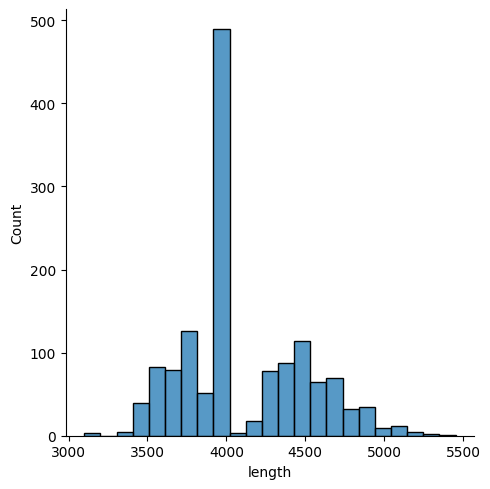

mean: 4111.0583629893235 median: 3995.0


In [74]:
sns.displot(df['length'])
plt.show()
print('mean:',df['length'].mean(),'median:',df['length'].median())

In [75]:
df.fillna({'length':df['length'].median()},inplace=True)

### Engineering the 'Max Power' column

In [76]:
df['max_power']=df['Max Power'].apply(lambda x:str(x).lower())
print(df['max_power'].value_counts())
df['max_power'].unique()

max_power
81.80bhp     50
81.86bhp     48
88.7bhp      48
74bhp        37
82bhp        31
             ..
180           1
82.85bhp      1
114.41bhp     1
91.18bhp      1
153.86bhp     1
Name: count, Length: 271, dtype: int64


array(['118.36bhp', '73bhp', '98.63bhp', '68.05bhp', '88.7bhp', '204bhp',
       '67.04bhp', '66.1bhp', '187.7bhp', '121.36bhp', '81.80bhp',
       '187.74bhp', '81.86bhp', '108.5bhp', '167.67bhp', '117.3bhp',
       '201.15bhp', '86.7bhp', '74bhp', '127bhp', '126.2bhp', '118.35bhp',
       '177.01bhp', '117.6bhp', '83.1bhp', '82bhp', '163.60bhp',
       '98.6bhp', '107.3bhp', '85 ps ', '108.45bhp', '138.1bhp',
       '108.62bhp', '86.79bhp', '74.02bhp', '121.3bhp', '82.4bhp',
       '241.4bhp', '88.5bhp', '245bhp', '147.8bhp', '167.62bhp', '258bhp',
       '75.10bhp', '67.05bhp', '68bhp', '113.98bhp', '78.9bhp',
       '113.43bhp', '182.38bhp', '88.76bhp', '90 ps ', '88.50bhp',
       '98.96bhp', '91.1bhp', '160.77bhp', '103.2bhp', '73.75bhp',
       '116.3bhp', '86.8bhp', '141bhp', '157.7bhp', '81.83bhp',
       '94.68bhp', '142 ', '100bhp', '203.2bhp', '143bhp', '252bhp',
       '459bhp', '210', '190bhp', '87.2bhp', '47.33bhp', '147.51bhp',
       '108.49bhp', '73.97bhp', '130bhp', 

In [77]:
a=[]
for i in list(df['max_power']):
    if 'bhp' not in i:
        a.append(i)
print(set(a))

{'105 ', '335.2', '170 ', 'nan', '90(66) ', '103.2 ', '38ps', '71 ps ', '118ps at 6,600 rpm', '102', '85ps ', '63 hp at 3200 rpm', '142 ', '66(90) / 4000', '83.1', '140', '85 ps ', '70', '65', '104.68', '60 ps ', '53.5', '104  ps ', '90 ps ', '210', '80 ps at 5200 rpm', '88.2', '180 ', '235 ', '174.33', '90ps at 4000rpm', '105 ps at 5250 rpm', '80 '}


In [78]:
avs=[]
for i in list(df['max_power']):
    if i=='nan':
        avs.append(np.nan)
    elif i=='66(90) / 4000' or i=='90(66) ':
        avs.append(65)
    elif i=='118ps at 6,600 rpm':
        avs.append(116.39)
    elif i=='105 ps at 5250 rpm':
        avs.append(103.56)
    elif i=='90ps at 4000rpm':
        avs.append(78.91)
    elif i=='80 ps at 5200 rpm':
        avs.append(99.77)
    elif i=='63 hp at 3200 rpm':
        avs.append(63)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['max_power']=avs
df['max_power'].value_counts()

max_power
82.0     161
89.0      94
67.0      93
74.0      62
88.0      53
        ... 
210.0      1
459.0      1
252.0      1
93.0       1
325.0      1
Name: count, Length: 135, dtype: int64

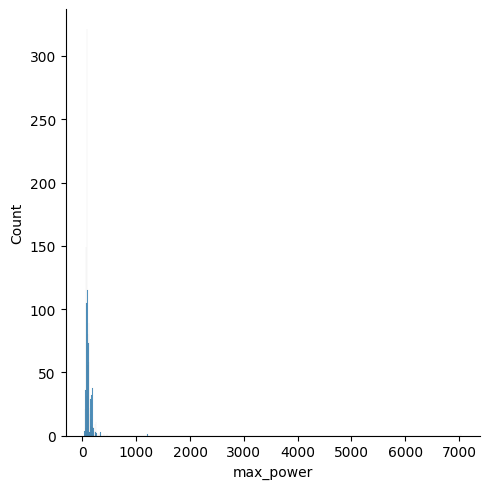

mean: 110.85821732954545 median: 89.0


In [79]:
sns.displot(df['max_power'])
plt.show()
print('mean:',df['max_power'].mean(),'median:',df['max_power'].median())

In [80]:
df.fillna({'max_power':df['max_power'].median()},inplace=True)

### Engineering the 'Max Torque' column

In [81]:
df['max_torque' ]=df['Max Torque'].apply(lambda x:str(x).lower())
print(df['max_torque' ].value_counts())
df['max_torque' ].unique()

max_torque
90nm@3500rpm                68
110nm@4800rpm               67
200nm@1750rpm               50
113nm@4200rpm               47
145nm@4600rpm               43
                            ..
22.4 kgm at 1750-2750rpm     1
13.5 kgm @ 4700 rpm          1
180 nm at 1440-1500rpm       1
480nm@1750rpm                1
340nm@1750-2750rpm           1
Name: count, Length: 282, dtype: int64


array(['172nm@1500-4000rpm', '101nm@3000rpm', '160nm@2800-3600rpm',
       '99.04nm@4500rpm', '110nm@4800rpm', '500nm@1600-1800rpm',
       '90nm@3500rpm', '400nm@1750-2500rpm', '150nm@4500rpm',
       '114.74nm@4200rpm', '113nm@4200rpm', '113.75nm@4000rpm',
       '260nm@1500-2750rpm', '350nm@1750-2500rpm', '145nm@4600rpm',
       '420nm@1400-3400rpm', '109nm@4500rpm', '94.14nm@3500rpm',
       '190nm@2000rpm', '245nm', '259.9nm@1900-2750rpm',
       '171.6nm@1500-4000rpm', '320nm@1500-3900rpm', '115nm@4000rpm',
       '114nm@4000rpm', '245nm@4000rpm', '200nm@1750rpm',
       '250nm@1400-2800rpm', '110 nm @ 4500 rpm ', '115nm@3500-3600rpm',
       '245nm@1750rpm', '173nm@4000rpm', '200nm@2000-3500rpm',
       '205nm@1800-2800rpm', '151nm@4850rpm', '400nm@1750-3000rpm',
       '108.5nm@5000rpm', '580nm@1400-3250rpm', '600nm@1500-3000rpm',
       '343nm@1400-2800rpm', '400nm@1400-2800rpm', '560nm@1500rpm',
       '170nm@1750-4000rpm', '95nm@2950-3800rpm', '560nm@1500-3000rpm',
       '1

In [82]:
s=[i if '15' in i else 'a' for i in list(df['max_torque'])]
s

['172nm@1500-4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '150nm@4500rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 '260nm@1500-2750rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '171.6nm@1500-4000rpm',
 'a',
 '320nm@1500-3900rpm',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '115nm@4000rpm',
 '115nm@3500-3600rpm',
 'a',
 '172nm@1500-4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 '151nm@4850rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '600nm@1500-3000rpm',
 'a',
 'a',
 '560nm@1500rpm',
 'a',
 'a',
 '560nm@1500-3000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '115nm@4500rpm',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 '115 nm @ 4500 rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 'a',
 '115nm@4000rpm',
 '153nm@3800rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '151nm@4850rpm',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 '115nm@4000rpm',
 'a',
 'a',
 'a',
 'a',
 'a',


In [83]:
avs=[]
for i in list(df['max_torque']):
    if i=='nan' :
        avs.append(np.nan)
    elif i=='11.4 kgm at 4,000 rpm':
        avs.append(round(111.79581))
    elif i=='22.4 kgm at 1750-2750rpm':
        avs.append(round(219.67))
    elif i=='13.5 kgm @ 4700 rpm':
        avs.append(round(132.38))
    elif i=='180 nm at 1440-1500rpm':
        avs.append(round(180))
    elif i=='13.5 kgm @ 4700 rpm':
        avs.append(round(219.87))
    elif i=='155 nm at 1600-2800 rpm':
        avs.append(round(155))  
    elif i=='210 / 1900':
        avs.append(round(210)) 
    elif i=='135 nm @ 2500 rpm ':
        avs.append(round(135)) 
    elif i=='148  nm @ 3500  rpm':
        avs.append(round(148))
    elif i=='146nm at 4800 rpm':
        avs.append(round(146))
    
    elif i[0].isnumeric()==True:
        b=[]
        if '@' in list(i):
            r=i.index('@')
            for k in range(r):
                if i[k].isnumeric()==True or i[k]=='.':
                    b.append(i[k])
        else:   
            for j in i:
                    if j.isnumeric()==True or j=='.':
                        b.append(j)
        
        avs.append(round(float(''.join(b))))
df['max_torque']=avs
df['max_torque'].value_counts()

max_torque
114.0    94
115.0    88
110.0    88
113.0    80
90.0     68
         ..
270.0     1
152.0     1
127.0     1
26.0      1
619.0     1
Name: count, Length: 132, dtype: int64

In [84]:
max(avs)

1533800

In [85]:
# sns.displot(df['max_torque'])
# plt.show()
print('mean:',df['max_torque'].mean(),'median:',df['max_torque'].median())

mean: 1274.9772727272727 median: 140.0


In [86]:
df.fillna({'max_torque':df['max_torque'].median()},inplace=True)

### Engineering the 'Width' column

In [87]:
df['width' ]=df['Width'].apply(lambda x:str(x).lower())
print(df['width'].value_counts())
df['width'].unique()

width
1695mm     112
1734mm      70
1660mm      53
1745mm      50
1682mm      48
          ... 
1917         1
1820         1
1665 mm      1
2099mm       1
1839mm       1
Name: count, Length: 199, dtype: int64


array(['1790', '1475mm', '1758', '1595mm', '1694mm', '2071mm', '1635mm',
       '1600mm', '1891mm', '1765mm', '1775mm', '1694 mm', '1827mm',
       '1735mm', '1660mm', '1811mm', '1818mm', '1695mm', '1855mm',
       '1680mm', '1550mm', '1780mm', '1770 mm', '2086mm', '1745mm',
       '1830mm', '1734mm', '2010mm', '1575mm', '1715mm', '1822mm', '1680',
       '1776mm', '1821mm', '1729mm', '1874mm', '1690mm', '2089mm',
       '1730mm', '2212 mm', '2020mm', '2142mm', '1682mm', '1894mm',
       '1636mm', '1854mm', '1645 mm', '1760mm', '1800mm', '1687mm',
       '1890mm', '1,730mm', '1694', '1699mm', '2173mm', '1835mm',
       '1860mm', '1737mm', '1,832 mm', '2141mm', '1960mm', '1735',
       '1811 mm', '2130mm', '1871mm', '2102mm', '1495mm', '1700mm',
       '1796mm', '1515mm', '1809mm', '1750mm', '1665mm', '1655', '1579mm',
       '1695', '1790mm', 'nan', '1706mm', '1730 mm', '1695 mm', '2019mm',
       '2218 mm', '1620 mm', '1821 mm', '1490', '1520', '2184mm', '1690',
       '2158mm', '1739

In [88]:
avs=[]
for i in list(df['width']):
    if i=='nan':
        avs.append(np.nan)
    elif i[0].isnumeric()==True:
        b=[]
        for j in i:
                if j.isnumeric()==True or j=='.':
                    b.append(j)
        
        avs.append(round(float(''.join(b[:4]))))
df['width']=avs
df['width'].value_counts()

width
1695.0    123
1734.0     71
1735.0     65
1680.0     60
1660.0     53
         ... 
1804.0      1
2145.0      1
1642.0      1
1795.0      1
1839.0      1
Name: count, Length: 151, dtype: int64

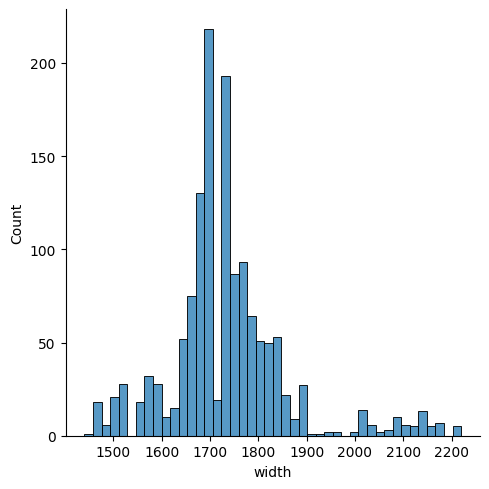

mean: 1733.9643874643875 median: 1730.0


In [89]:
sns.displot(df['width'])
plt.show()
print('mean:',df['width'].mean(),'median:',df['width'].median())

In [90]:
df.fillna({'width':df['width'].median()},inplace=True)

In [91]:
df.head()

,bt,owner,oem,Registration Year,Engine Displacement,Seating Capacity,Alloy Wheel Size,Turbo Charger,Engine,Front Brake Type,...,front_brake_type,gear_box,mileage,wheel_base,height,kerb_weight,length,max_power,max_torque,width
0,SUV,1_owner,kia,2022,998 cc,5,16,Yes,998 CC,Disc,...,solid disc,7 speed dct,19.0,2500.0,1642.0,1465.0,3995.0,118.0,172.0,1790.0
1,Minivans,1_owner,maruti,Feb 2015,1196 cc,7,NaN,No,1196 CC,Ventilated Disc,...,ventilated discs,5 speed,15.0,2350.0,1800.0,943.0,3675.0,73.0,101.0,1475.0
2,SUV,1_owner,other,2021,999 cc,5,16,Yes,999 CC,Disc,...,solid disc,5 speed,20.0,2500.0,1572.0,1014.0,3994.0,99.0,160.0,1758.0
3,Hatchback,1_owner,hyundai,May 2015,1086 cc,5,NaN,No,1086 CC,Ventilated Disc,...,ventilated discs,5 speed,20.0,2380.0,1550.0,860.0,3585.0,68.0,99.0,1595.0
4,Hatchback,1_owner,honda,2015,1199 cc,5,15,No,1199 CC,Disc,...,solid disc,5 speed,19.0,2530.0,1544.0,1042.0,3955.0,89.0,110.0,1694.0


### Checking for null values on the newly engineered columns

In [92]:
pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})

,dtypes,null_count,unique_values,percent_of_null_values
bt,object,0,7,0.000000
owner,object,0,4,0.000000
oem,object,0,16,0.000000
Registration Year,object,0,195,0.000000
Engine Displacement,object,20,91,0.014094
Seating Capacity,int64,0,7,0.000000
Alloy Wheel Size,object,468,16,0.329810
Turbo Charger,object,144,5,0.101480
Engine,object,0,92,0.000000
Front Brake Type,object,19,20,0.013390


In [93]:
df.dropna(subset=['front_brake_type','Rear Brake Type','No of Cylinder','Values per Cylinder'],inplace=True)

These two columns namely 'No of Cylinder','Values per Cylinder' has null values ,so I'm dropping the rows considering these two columns as subset in the entire dataframe

In [94]:
pd.DataFrame({'dtypes':df.dtypes,'null_count':df.isnull().sum(),
              'unique_values':df.nunique(),
             'percent_of_null_values':df.isnull().mean()})


,dtypes,null_count,unique_values,percent_of_null_values
bt,object,0,7,0.000000
owner,object,0,4,0.000000
oem,object,0,16,0.000000
Registration Year,object,0,188,0.000000
Engine Displacement,object,19,88,0.013630
Seating Capacity,int64,0,6,0.000000
Alloy Wheel Size,object,467,16,0.335007
Turbo Charger,object,128,5,0.091822
Engine,object,0,88,0.000000
Front Brake Type,object,0,20,0.000000


In [95]:
new_all_selected_features=['owner', 'oem','body_type', 'registration_year', 
    'alloy_wheel_size', 'turbo_charger', 'front_brake_type', 'gear_box',
   'Rear Brake Type','seating_capacity','kms', 'price_new', 'engine_displacement', 'mileage', 'wheel_base',
   'height', 'kerb_weight', 'length', 'max_power', 'max_torque','width']
for i in car_features:
    new_all_selected_features.append(i)

In [96]:
df=df[new_all_selected_features]
df.head()

,owner,oem,body_type,registration_year,alloy_wheel_size,turbo_charger,front_brake_type,gear_box,Rear Brake Type,seating_capacity,...,wheel_base,height,kerb_weight,length,max_power,max_torque,width,No Door Numbers,No of Cylinder,Values per Cylinder
0,1_owner,kia,suv,2022,r16,yes,solid disc,7 speed dct,Drum,5,...,2500.0,1642.0,1465.0,3995.0,118.0,172.0,1790.0,5,3.0,4.0
1,1_owner,maruti,other,2015,r16,no,ventilated discs,5 speed,Drum,7,...,2350.0,1800.0,943.0,3675.0,73.0,101.0,1475.0,5,4.0,4.0
2,1_owner,other,suv,2021,r16,yes,solid disc,5 speed,Drum,5,...,2500.0,1572.0,1014.0,3994.0,99.0,160.0,1758.0,5,3.0,4.0
3,1_owner,hyundai,hatchback,2015,r16,no,ventilated discs,5 speed,Drum,5,...,2380.0,1550.0,860.0,3585.0,68.0,99.0,1595.0,5,4.0,3.0
4,1_owner,honda,hatchback,2015,r15,no,solid disc,5 speed,Drum,5,...,2530.0,1544.0,1042.0,3955.0,89.0,110.0,1694.0,5,4.0,4.0


In [97]:
#categorical columns list
cc=[]
#numerical columns list
nc=[]
for i in df.columns:
    if df[i].dtype=='O':
        cc.append(i)
    else:
        nc.append(i)
print('categorical_columns:',cc)
print()
print('numerical_columns:',nc)

categorical_columns: ['owner', 'oem', 'body_type', 'registration_year', 'alloy_wheel_size', 'turbo_charger', 'front_brake_type', 'gear_box', 'Rear Brake Type', 'seating_capacity']

numerical_columns: ['kms', 'price_new', 'engine_displacement', 'mileage', 'wheel_base', 'height', 'kerb_weight', 'length', 'max_power', 'max_torque', 'width', 'No Door Numbers', 'No of Cylinder', 'Values per Cylinder']


### Finding outliers in categorical columns and replacing it with upper and lower limit values respectively

In [98]:
def plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

   # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.show()

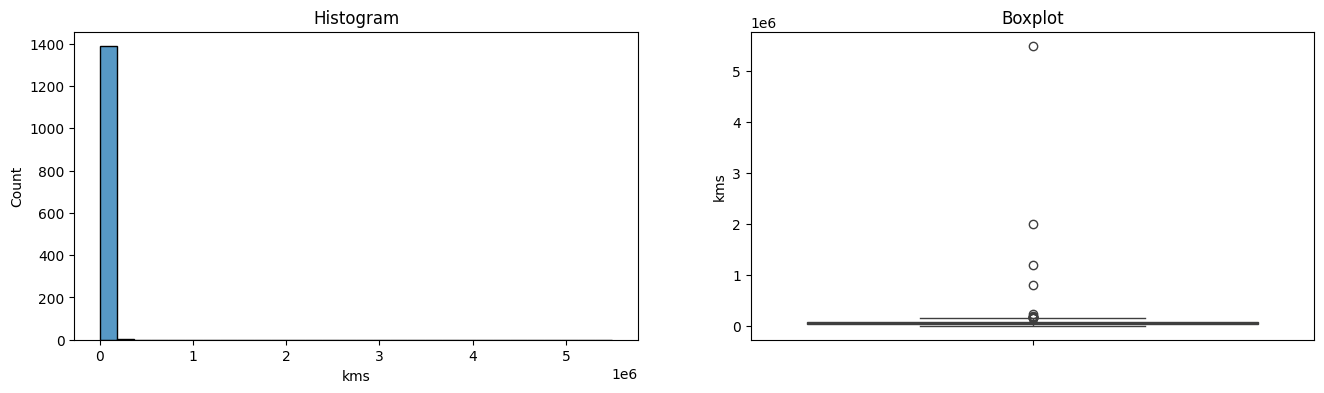

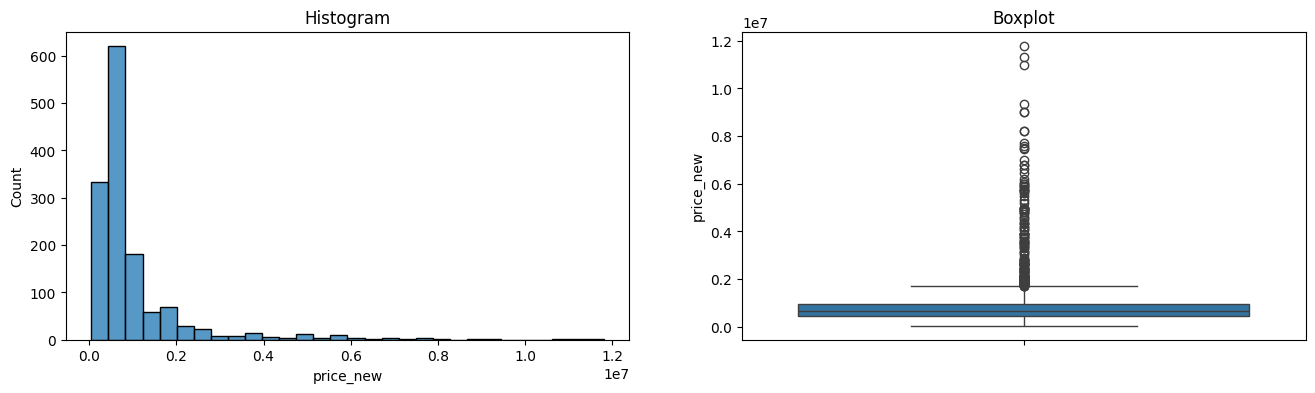

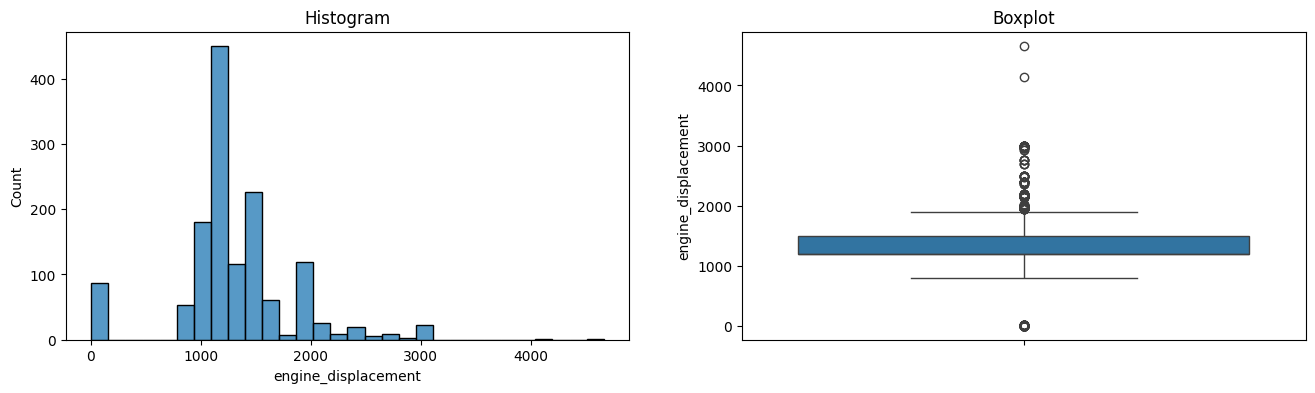

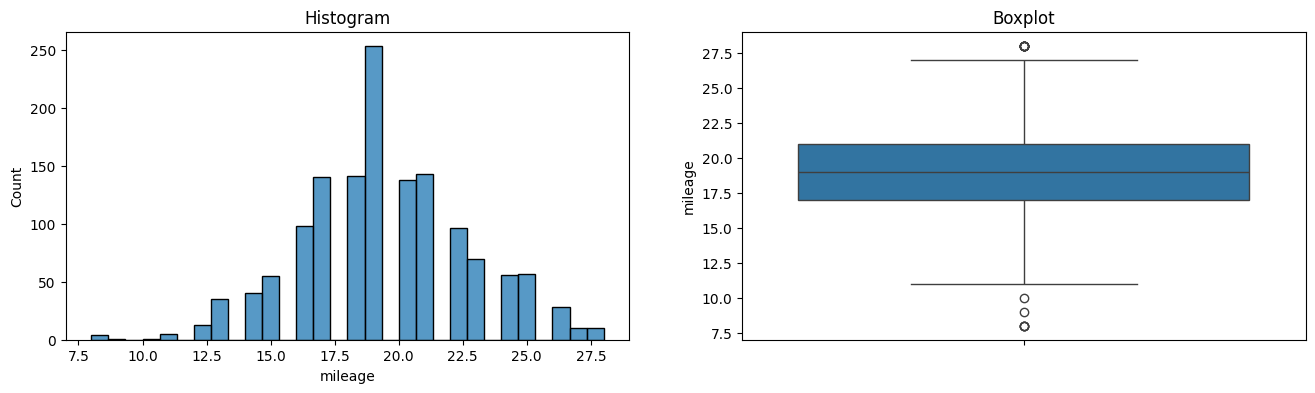

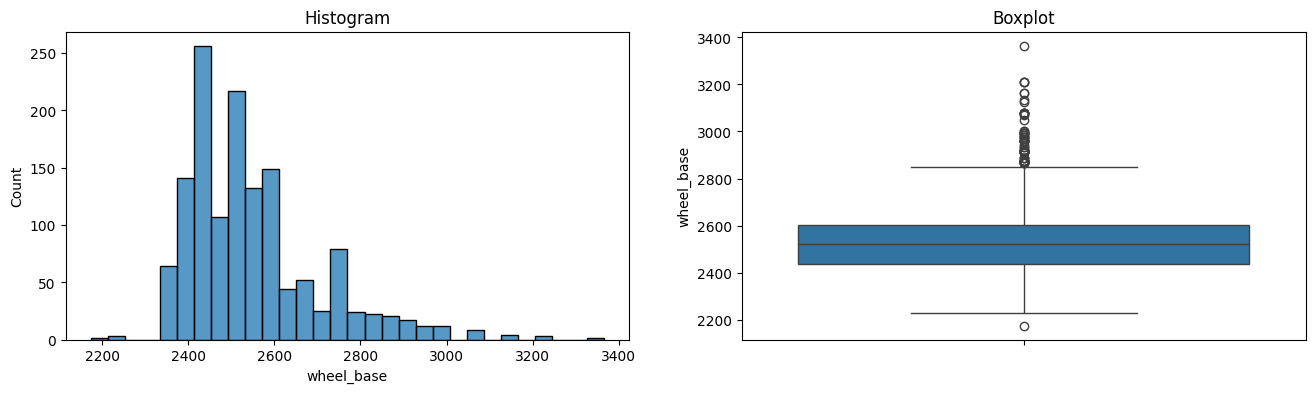

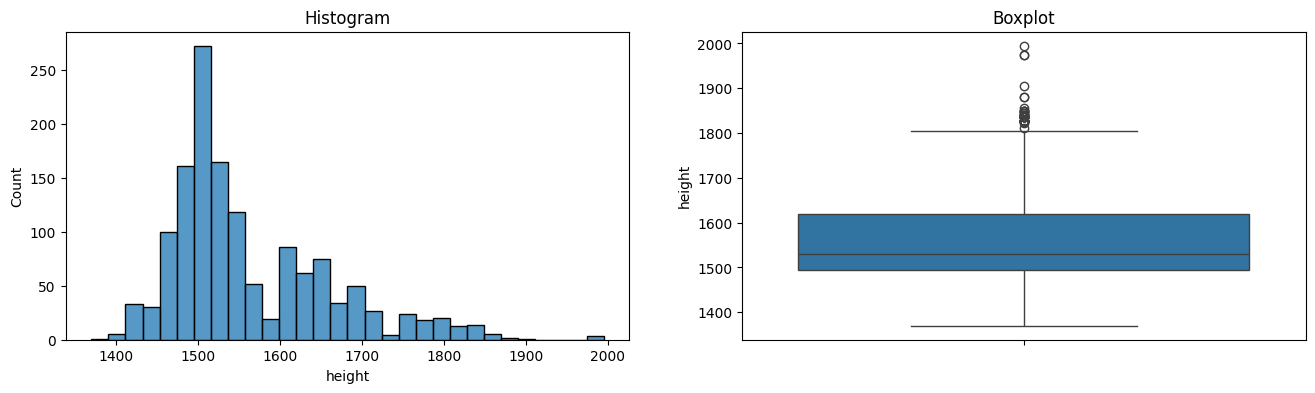

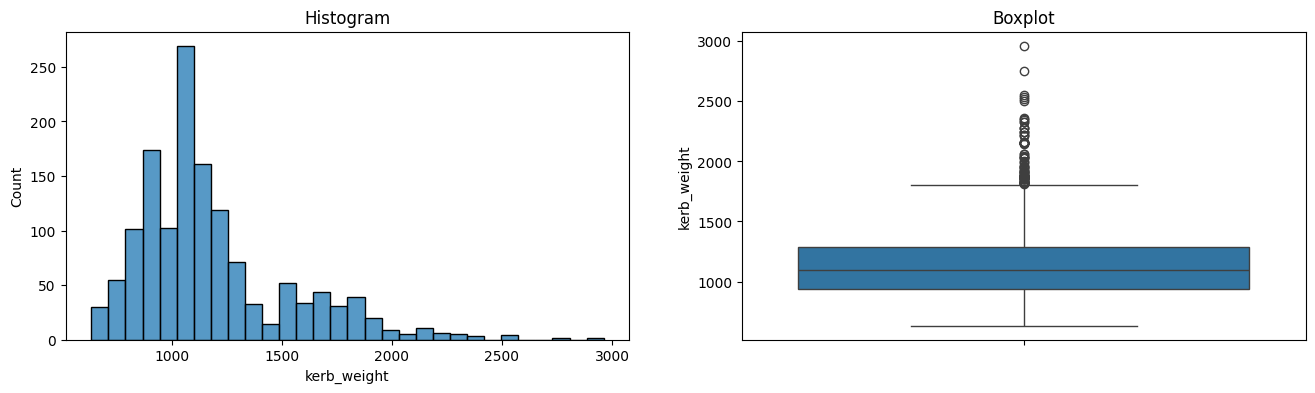

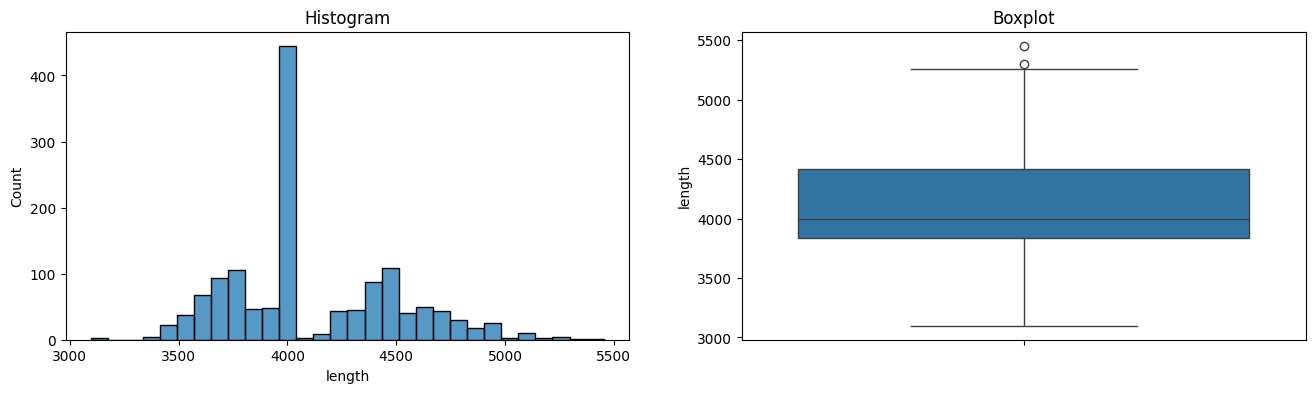

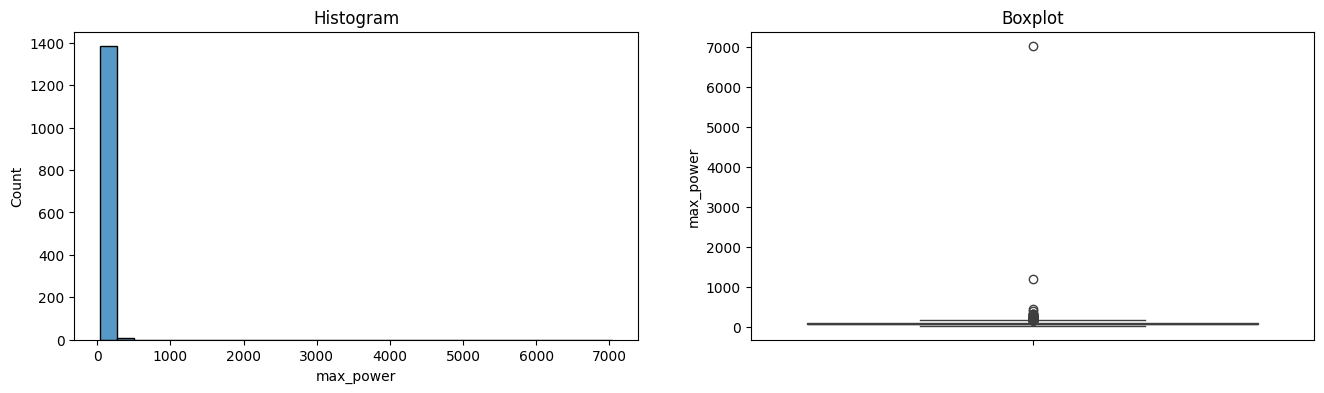

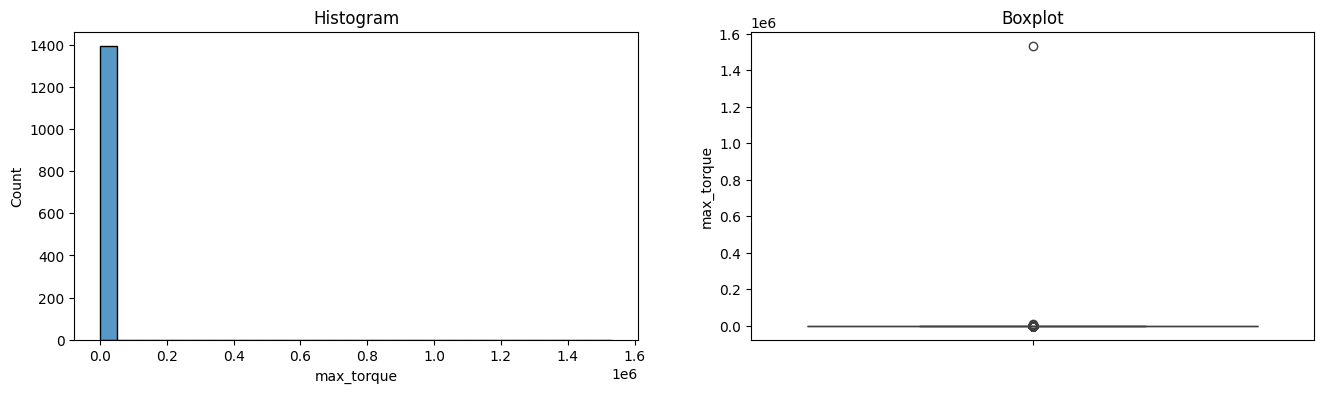

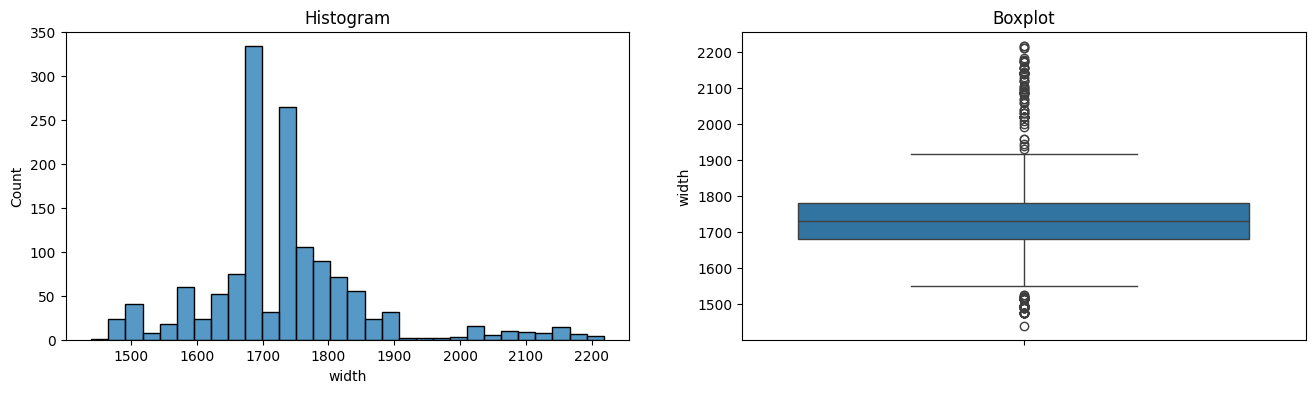

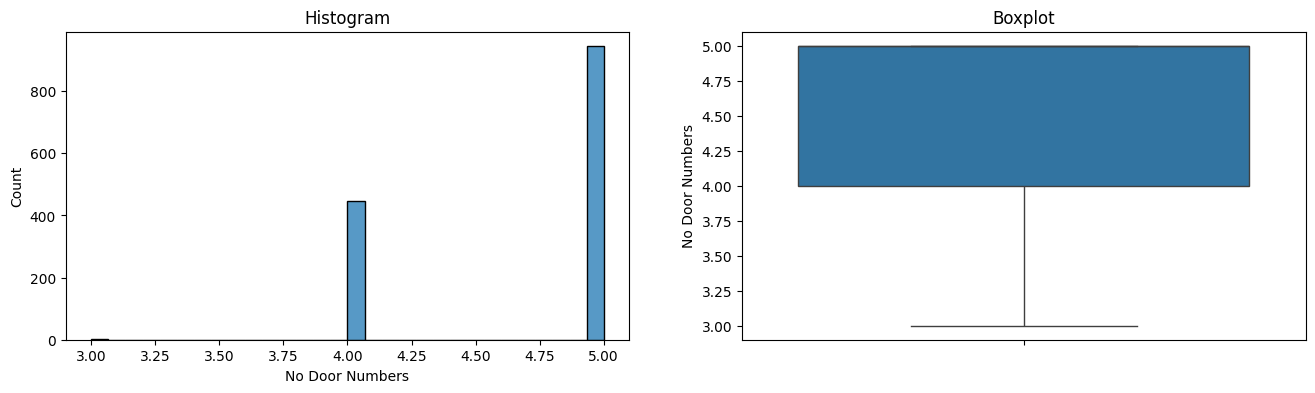

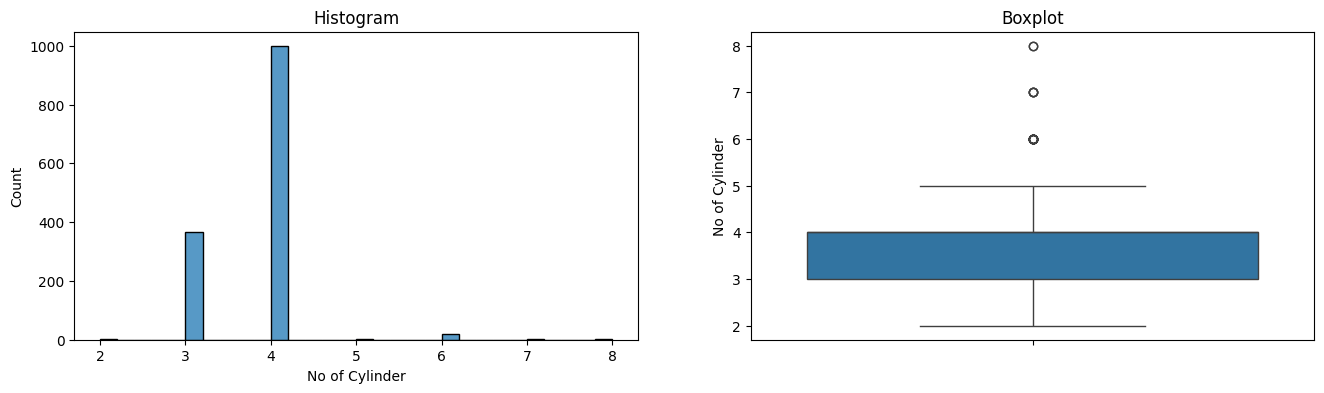

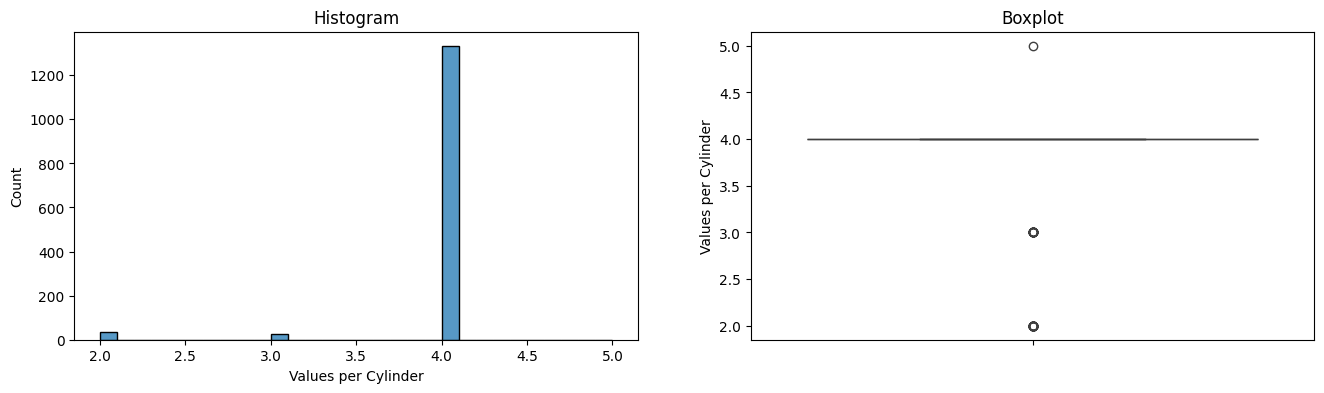

In [99]:
for m in nc:
    plots(df, m)

In [100]:
def find_skewed_boundaries(df, variable, distance):

    # Calculating the boundaries outside which sit the outliers
    # for skewed distributions


    IQR = round(df[variable].quantile(0.75) - df[variable].quantile(0.25))

    lower_boundary = abs(round(df[variable].quantile(0.25) - (IQR * distance)))
    upper_boundary = abs(round(df[variable].quantile(0.75) + (IQR * distance)))

    return upper_boundary, lower_boundary

In [101]:
ul=[]
for v in nc:
    upper_limit, lower_limit = find_skewed_boundaries(df, v, 1.5)
    ul.append((v,upper_limit, lower_limit))

In [102]:
def replace_outlier(dataset,variable,upper_limit,lower_limit):
    dataset[variable]= np.where(dataset[variable] > upper_limit, upper_limit,
                       np.where(dataset[variable] < lower_limit, lower_limit, dataset[variable]))

In [103]:
for v1 in range(len(ul)):
    replace_outlier(df,ul[v1][0],ul[v1][1],ul[v1][2])

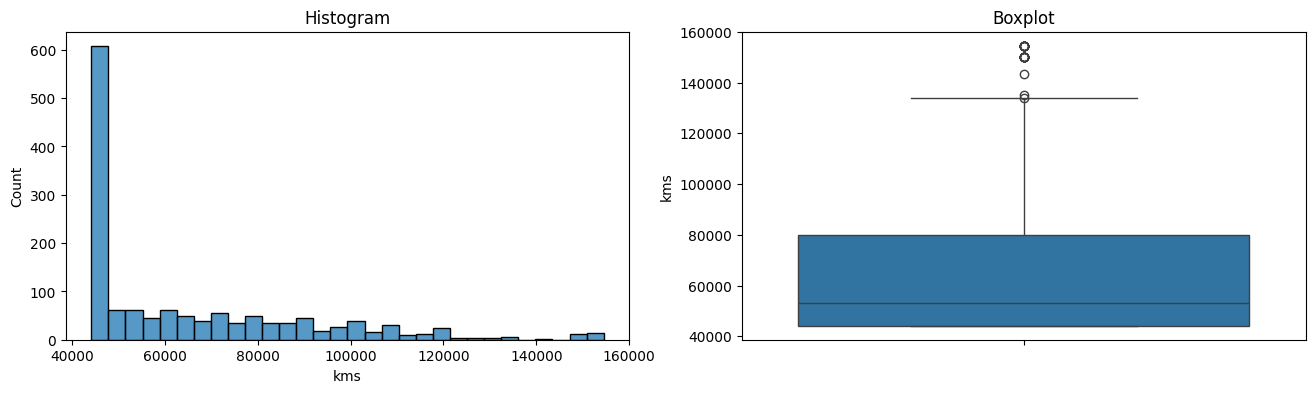

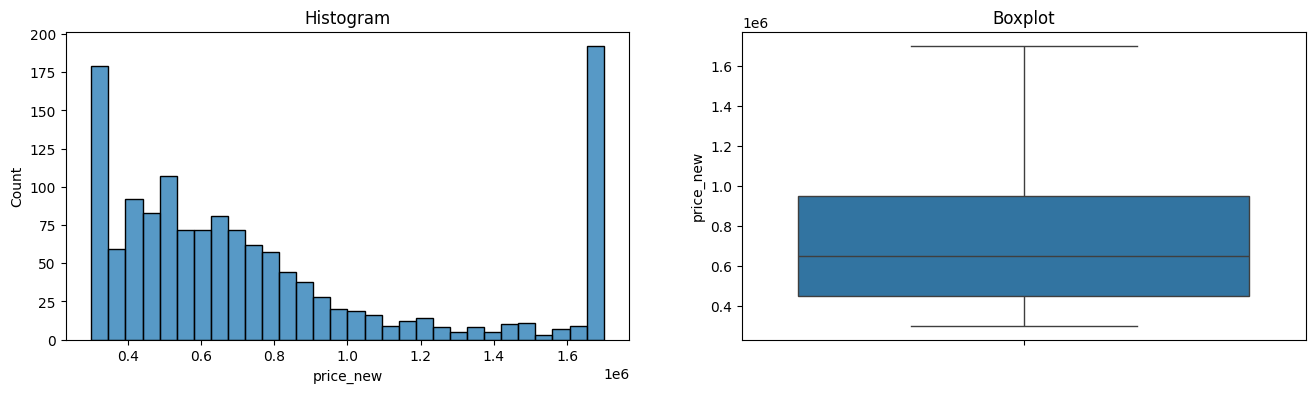

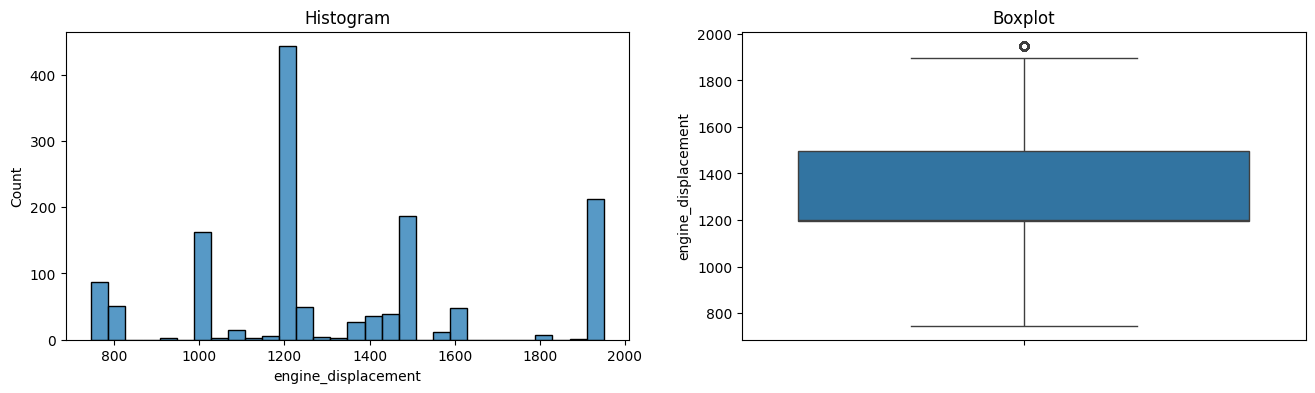

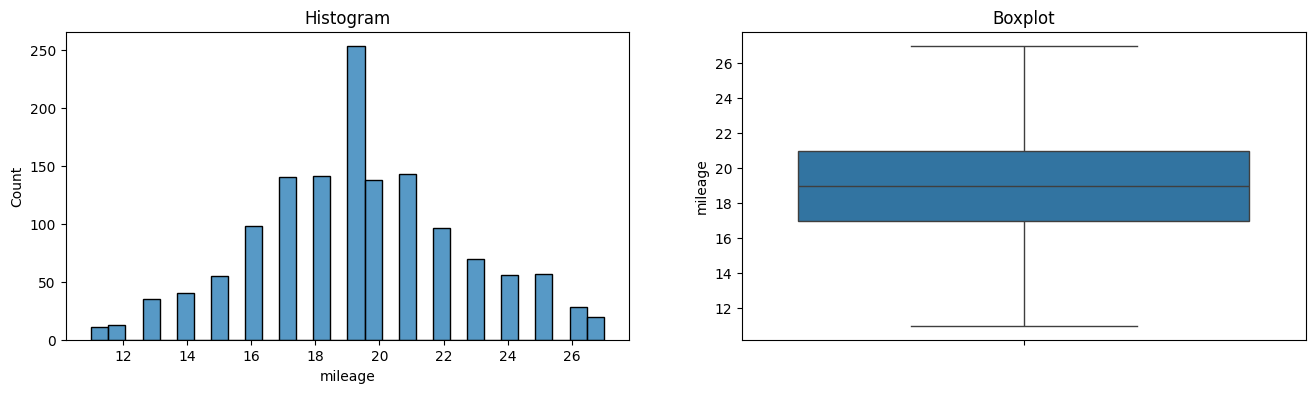

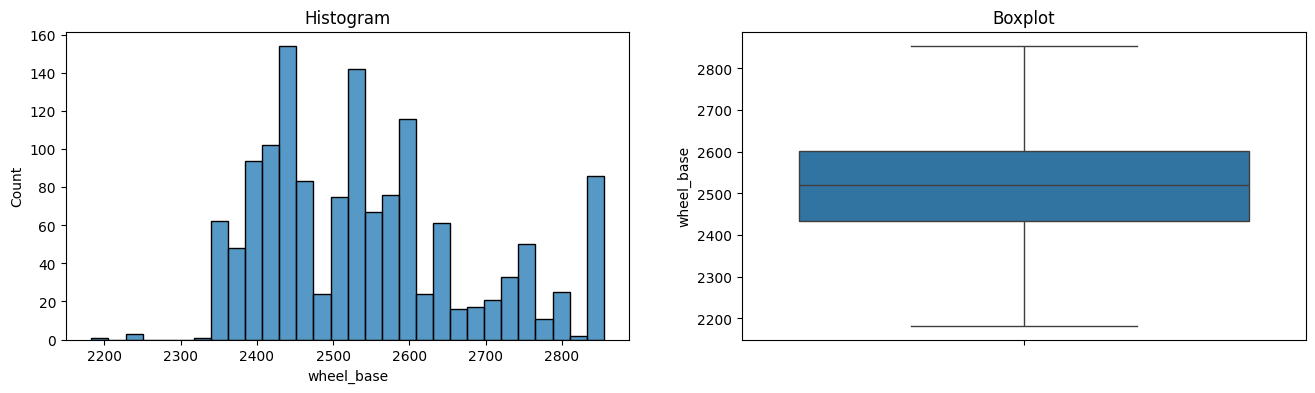

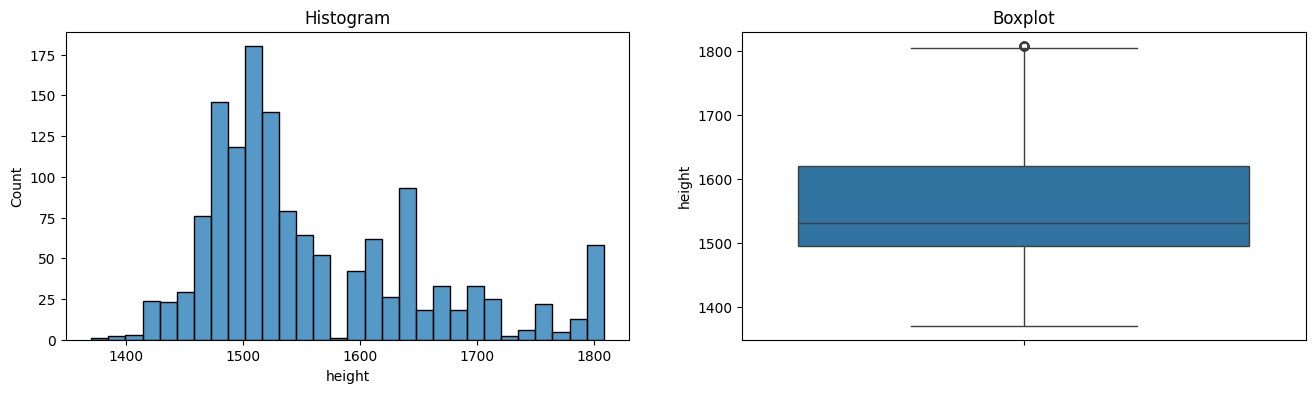

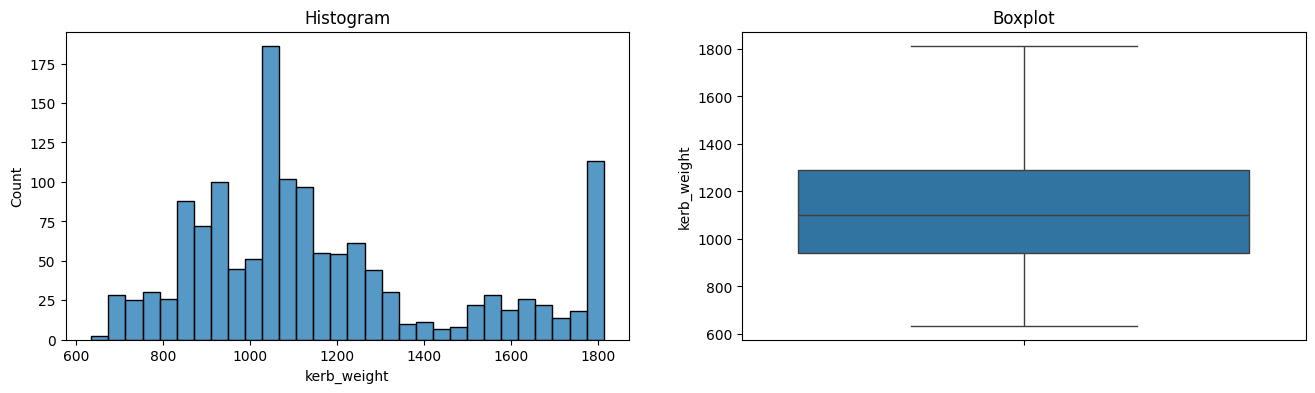

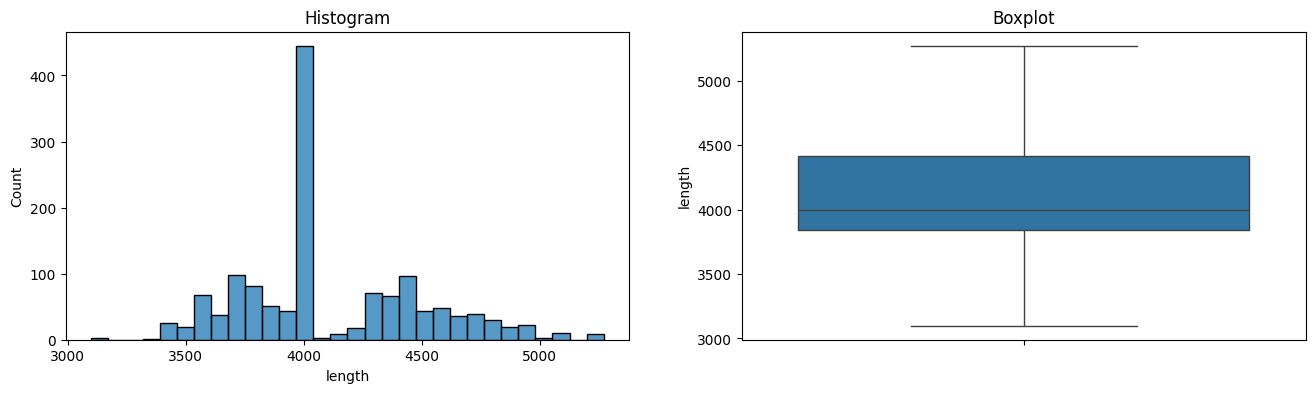

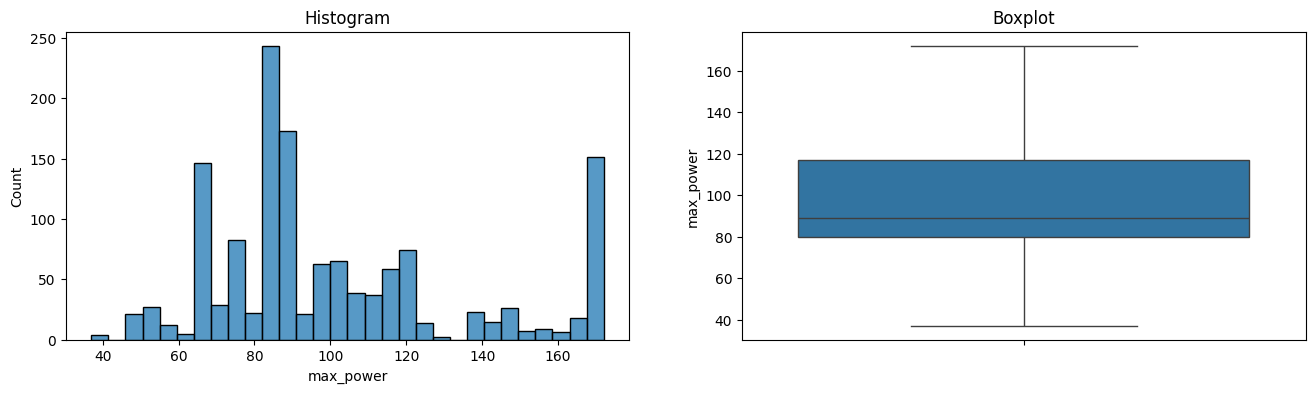

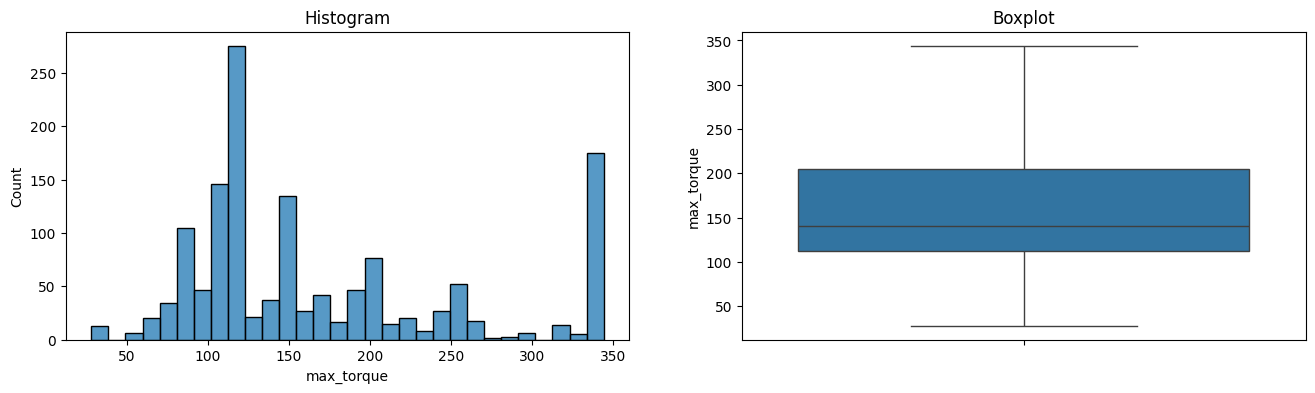

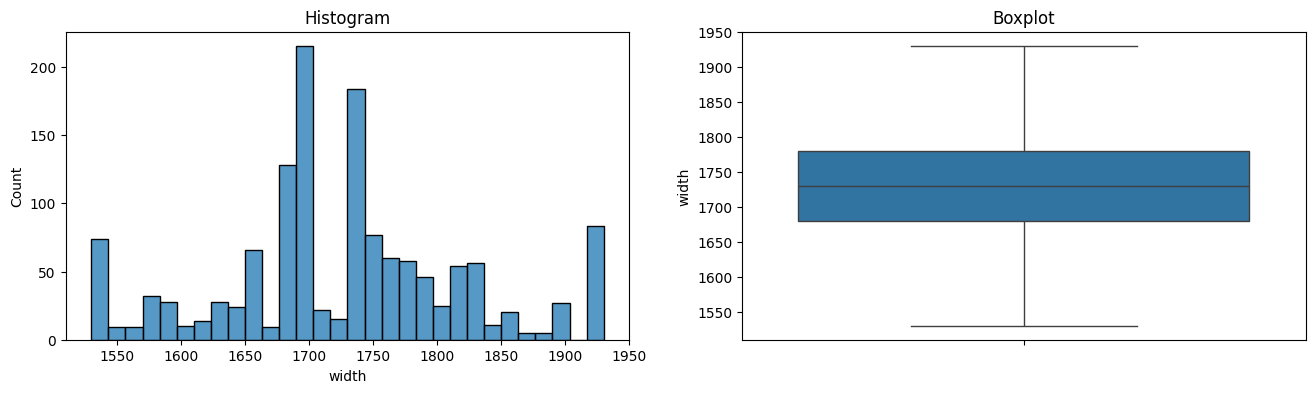

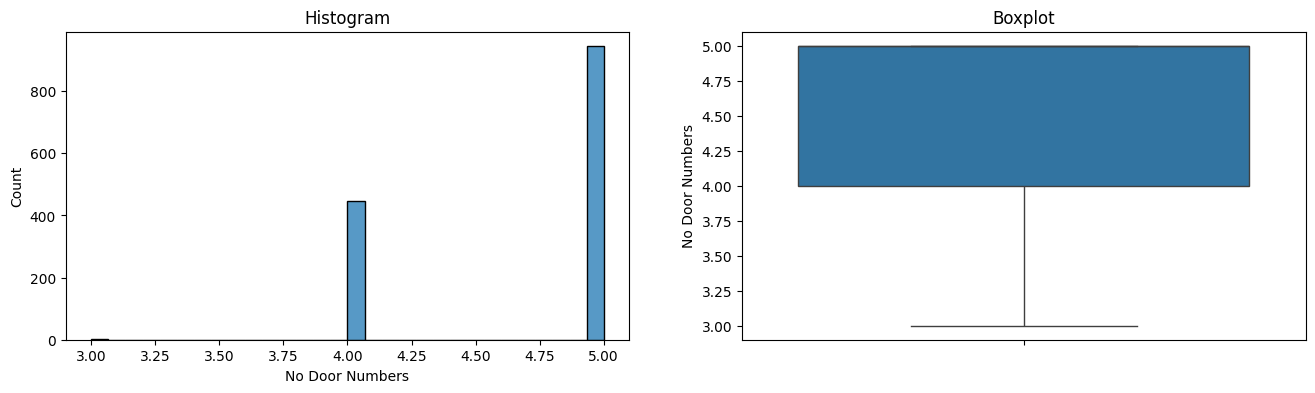

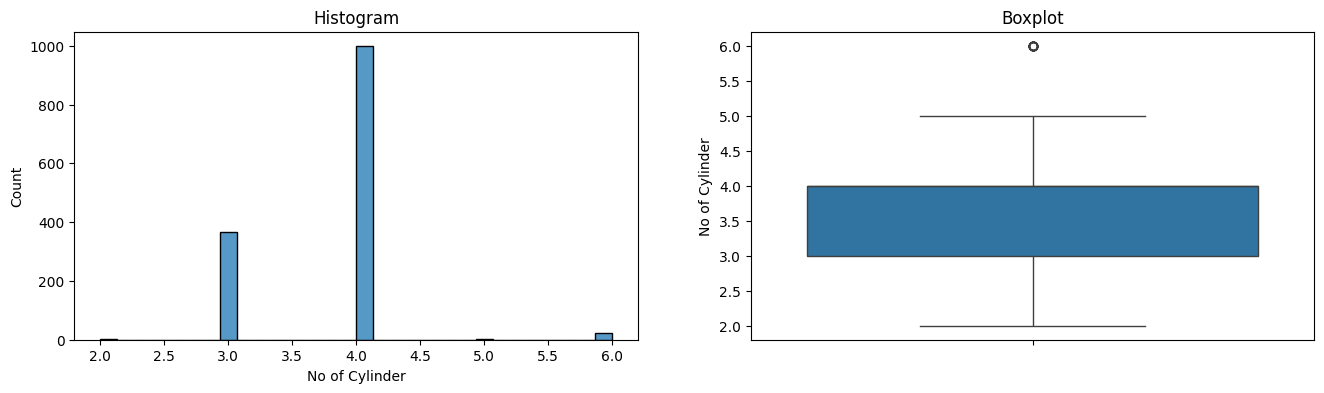

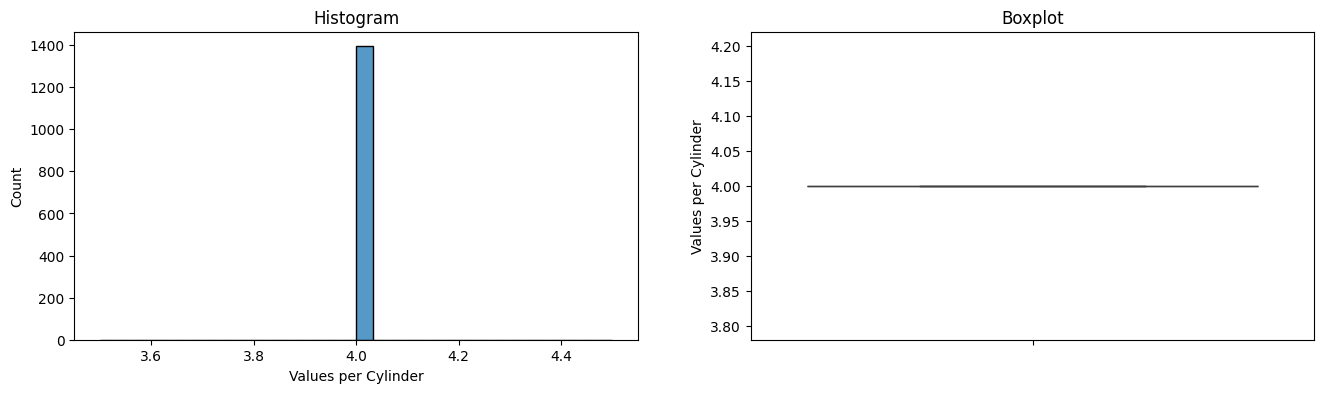

In [104]:
for m in nc:
    plots(df, m)

In [105]:
# for Q-Q plots
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer

def diagnostic_plots(df, variable):

    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable

    plt.figure(figsize=(15, 6))

    # histogram
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.title(f"Histogram of {variable}")

    # q-q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(f"Q-Q plot of {variable}")

    plt.show()



### Changing the distribution of the 'price_new' and 'kms' columns

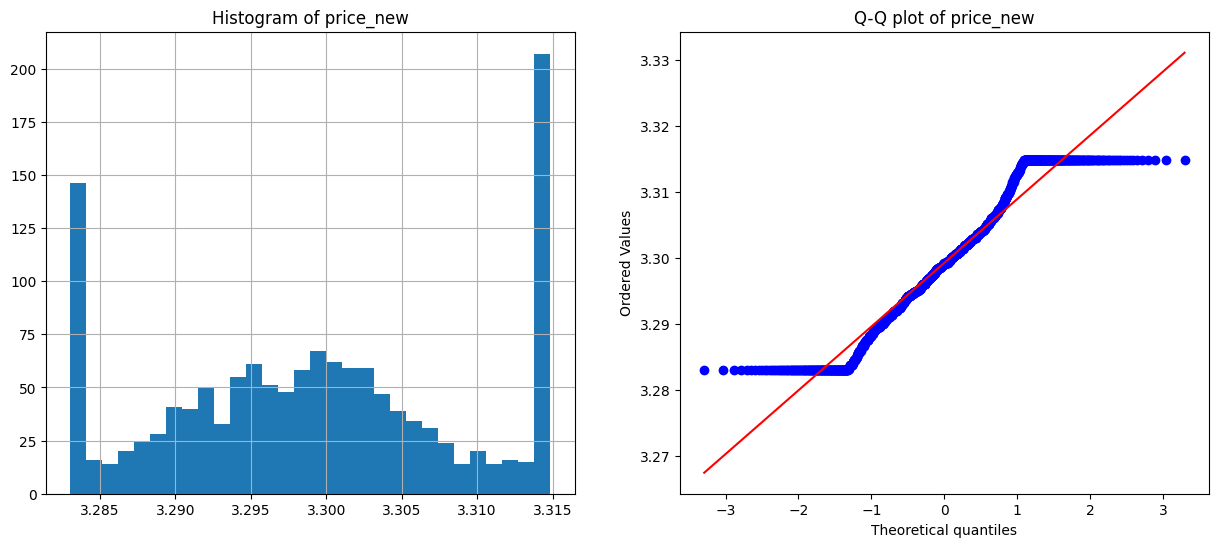

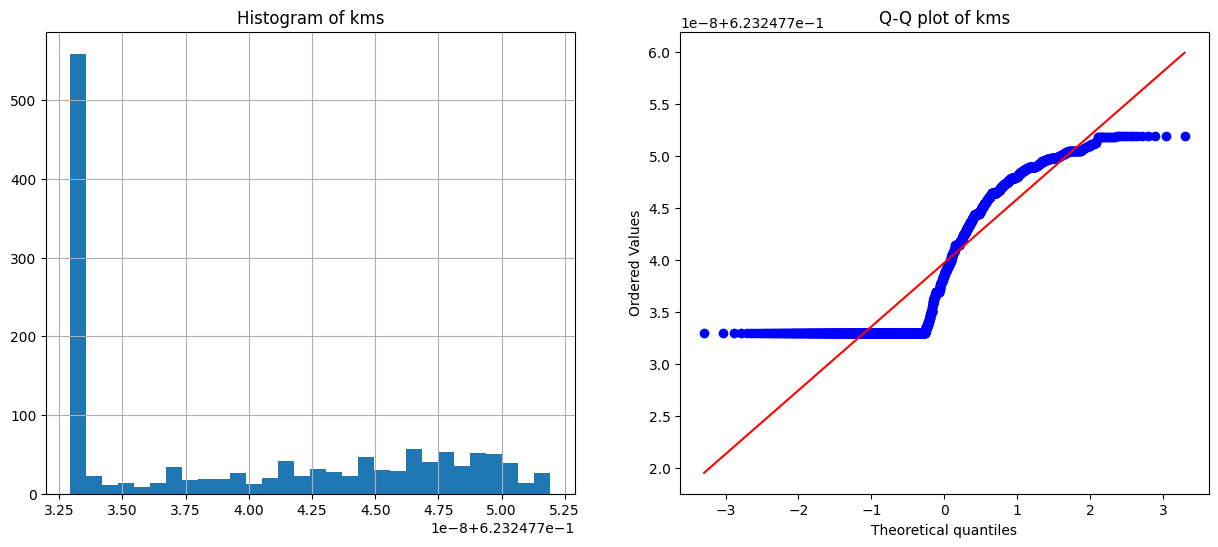

In [106]:
# with open-source packages
from sklearn.preprocessing import PowerTransformer

#transforming the ''price_new' column using "box-cox"
transformer1 = PowerTransformer(method="box-cox", standardize=False)
transformer1.fit(df[['price_new']])
# transformer1.set_output(transform="pandas")
df['price_new']= transformer1.transform(df[['price_new']])

diagnostic_plots(df, 'price_new')

#transforming the 'kms' column using "box-cox"
transformer2 = PowerTransformer(method="box-cox", standardize=False)
transformer2.fit(df[['kms']])
# transformer2.set_output(transform="pandas")
df['kms']= transformer2.transform(df[['kms']])

diagnostic_plots(df, 'kms')

In [107]:
from sklearn.model_selection import train_test_split

# for encoding with feature-engine
from feature_engine.encoding import MeanEncoder

In [108]:
s=new_all_selected_features.index('price_new')
s1=new_all_selected_features[s]

# Removing the 'price_new' column from 'new_all_selected_features' list
new_all_selected_features.pop(s)
new_all_selected_features

['owner',
 'oem',
 'body_type',
 'registration_year',
 'alloy_wheel_size',
 'turbo_charger',
 'front_brake_type',
 'gear_box',
 'Rear Brake Type',
 'seating_capacity',
 'kms',
 'engine_displacement',
 'mileage',
 'wheel_base',
 'height',
 'kerb_weight',
 'length',
 'max_power',
 'max_torque',
 'width',
 'No Door Numbers',
 'No of Cylinder',
 'Values per Cylinder']

In [109]:
y=df[s1]
X=df[new_all_selected_features]


X_train, X_test, y_train, y_test = train_test_split(
    X,  # predictors
    y,  # target
    test_size=0.20,  # percentage of obs in test set
    random_state=0,
)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1115, 23), (279, 23))

In [110]:
mean_enc = MeanEncoder(variables=cc) #cc- categorical columns

In [111]:
mean_enc.fit(X_train, y_train)

MeanEncoder(variables=['owner', 'oem', 'body_type', 'registration_year',
                       'alloy_wheel_size', 'turbo_charger', 'front_brake_type',
                       'gear_box', 'Rear Brake Type', 'seating_capacity'])

In [112]:
X_train = mean_enc.transform(X_train)
X_test = mean_enc.transform(X_test)

# let's explore the result
X_train.head()

C:\Users\Kavin\anaconda3\envs\car_dekho_mlproject\lib\site-packages\feature_engine\encoding\base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) Rear Brake Type.
  warnings.warn(


,owner,oem,body_type,registration_year,alloy_wheel_size,turbo_charger,front_brake_type,gear_box,Rear Brake Type,seating_capacity,...,wheel_base,height,kerb_weight,length,max_power,max_torque,width,No Door Numbers,No of Cylinder,Values per Cylinder
1350,3.300786,3.313563,3.300384,3.296355,3.314636,3.305873,3.297746,3.310118,3.313933,3.298431,...,2855.0,1455.0,1610.0,4933.0,172.0,320.0,1874.0,4,4.0,4.0
415,3.296537,3.296108,3.300384,3.293990,3.297201,3.294547,3.299999,3.294269,3.296408,3.298431,...,2425.0,1520.0,1120.0,3995.0,82.0,114.0,1660.0,4,4.0,4.0
491,3.300786,3.298471,3.300384,3.306340,3.297880,3.299475,3.299999,3.294269,3.296408,3.298431,...,2470.0,1498.0,907.0,3995.0,88.0,110.0,1695.0,4,4.0,4.0
1247,3.296537,3.304009,3.304341,3.294184,3.314636,3.305873,3.299999,3.314542,3.311601,3.298431,...,2660.0,1605.0,1655.0,4355.0,172.0,340.0,1930.0,4,4.0,4.0
908,3.300786,3.287942,3.292519,3.299673,3.297880,3.294547,3.299999,3.294269,3.296408,3.298431,...,2348.0,1541.0,770.0,3429.0,54.0,72.0,1560.0,5,3.0,4.0


In [113]:
X_test.isnull().sum()

owner                  0
oem                    0
body_type              0
registration_year      0
alloy_wheel_size       0
turbo_charger          0
front_brake_type       0
gear_box               0
Rear Brake Type        4
seating_capacity       0
kms                    0
engine_displacement    0
mileage                0
wheel_base             0
height                 0
kerb_weight            0
length                 0
max_power              0
max_torque             0
width                  0
No Door Numbers        0
No of Cylinder         0
Values per Cylinder    0
dtype: int64

In [114]:
X_test['price_new']=y_test
X_test.dropna(inplace=True)
X_test.isnull().sum()

owner                  0
oem                    0
body_type              0
registration_year      0
alloy_wheel_size       0
turbo_charger          0
front_brake_type       0
gear_box               0
Rear Brake Type        0
seating_capacity       0
kms                    0
engine_displacement    0
mileage                0
wheel_base             0
height                 0
kerb_weight            0
length                 0
max_power              0
max_torque             0
width                  0
No Door Numbers        0
No of Cylinder         0
Values per Cylinder    0
price_new              0
dtype: int64

In [115]:
y_test=X_test['price_new']
X_test=X_test[new_all_selected_features]
X_test.shape

(275, 23)

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

In [117]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [118]:
# Let's train a linear model.

# Instantiate a linear model.
linreg = LinearRegression()

# Train the model.
linreg.fit(scaler.transform(X_train), y_train)

# Make predictions on the train set and calculate
# the mean squared error.
# print('Train set')
pred_train = linreg.predict(scaler.transform(X_train))
print('Linear Regression rmse: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train))))
print('Linear Regression r2-score: {}'.format(r2_score(y_train, pred_train)))
# Make predictions on the test set and calculate
# the mean squared error.
print('Test set')
pred_test = linreg.predict(scaler.transform(X_test))
print('Linear Regression rmse: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test))))
print('Linear Regression r2-score: {}'.format(r2_score(y_test, pred_test)))
print()

Linear Regression rmse: 0.0033045210348590166
Linear Regression r2-score: 0.8906458490689214
Test set
Linear Regression rmse: 0.002991954245931487
Linear Regression r2-score: 0.9005611768504886



In [119]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [120]:
hr=HistGradientBoostingRegressor(learning_rate=0.05,max_leaf_nodes=300,max_depth=200,
                                               max_iter=1000,
                                               random_state=2023)
# Train the model.
hr.fit(scaler.fit_transform(X_train), y_train)

# Make predictions on the train set and calculate
# the mean squared error.
print('Train set')
pred_train = hr.predict(scaler.transform(X_train))
print('HistGradientBoostingRegressor rmse: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train))))
print('HistGradientBoostingRegressor r2-score: {}'.format(r2_score(y_train, pred_train)))
# Make predictions on the test set and calculate
# the mean squared error.
print('Test set')
pred_test = hr.predict(scaler.transform(X_test))
print('HistGradientBoostingRegressor rmse: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test))))
print('HistGradientBoostingRegressor r2-score: {}'.format(r2_score(y_test, pred_test)))
print()

Train set
HistGradientBoostingRegressor rmse: 0.00031993681447271274
HistGradientBoostingRegressor r2-score: 0.998974946190098
Test set
HistGradientBoostingRegressor rmse: 0.002146762371007815
HistGradientBoostingRegressor r2-score: 0.9488065935706106



### Inverse transforming the target column and comparing the 'actual' and 'predicted' values

In [121]:
u1=pd.concat([y_train,y_test],axis=0)
u2=pd.concat([pd.Series(pred_train),pd.Series(pred_test)],axis=0)

pred=transformer1.inverse_transform(pd.DataFrame(u2,columns=['price_new']))
y= transformer1.inverse_transform(u1.values.reshape(-1, 1))
x=pd.DataFrame({'rv':list(y),'pv':list(pred)})
x['residuals']=(x['rv']-x['pv'])
x['error']=(((x['rv']-x['pv']))/(x['rv']))

x['residuals_cor']=[i[0] for i in x['residuals']]
x['error_cor']=[i[0] for i in x['error']]
x.head()

C:\Users\Kavin\anaconda3\envs\car_dekho_mlproject\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


,rv,pv,residuals,error,residuals_cor,error_cor
0,[1699999.9999999953],[1705075.6151532987],[-5075.61515330337],[-0.002985655972531402],-5075.615153,-0.002986
1,[450000.00000000594],[450439.1090395095],[-439.10903950355714],[-0.0009757978655634474],-439.109040,-0.000976
2,[745000.0000000226],[748932.0486795595],[-3932.048679536907],[-0.005277917690653406],-3932.048680,-0.005278
3,[1699999.9999999953],[1696058.6485959324],[3941.351404062938],[0.0023184420023899697],3941.351404,0.002318
4,[301000.00000000215],[302468.36113358487],[-1468.3611335827154],[-0.004878276191304667],-1468.361134,-0.004878


In [122]:
x['residuals'].max(),x['residuals'].min()

(array([410625.00870776]), array([-425154.71402978]))

In [123]:
round(list(x['error'].max())[0],2),round(list(x['error'].min())[0],2)

(0.49, -0.33)

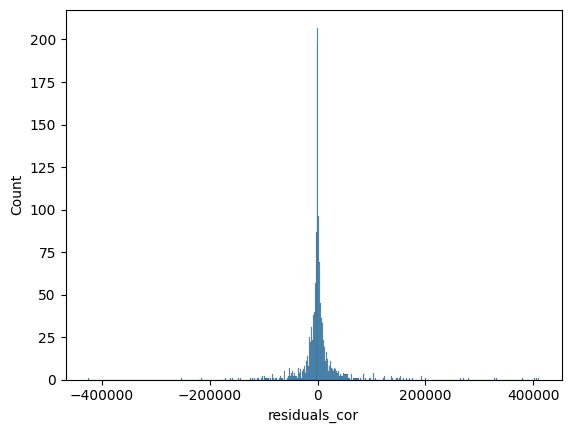

In [124]:
sns.histplot(x['residuals_cor'])
plt.show()

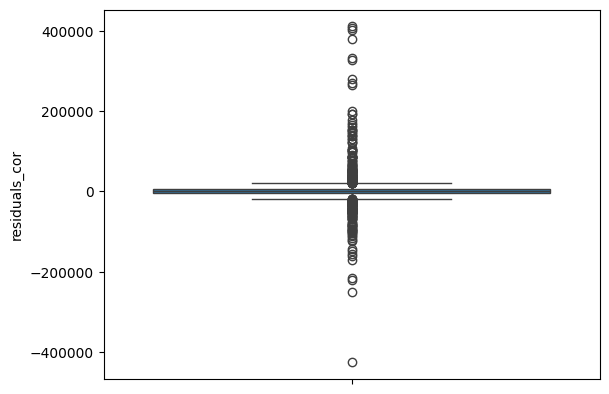

In [125]:
sns.boxplot(x['residuals_cor'])
plt.show()

In [126]:
x['residuals_cor'].describe()

count      1390.000000
mean       2634.106378
std       44453.234370
min     -425154.714030
25%       -4794.286628
50%         -14.697222
75%        5131.050540
max      410625.008708
Name: residuals_cor, dtype: float64

### From 248 features ,through various analysis and tests I used only 23 features to predict the 'price' of the cars.Hope the project results are good!!! 